In [8]:
# VIX Feature Diagnostics - Execute in Jupyter Lab from /src
# This cell contains the complete diagnostic suite

import json,sqlite3,warnings
from collections import defaultdict
from datetime import datetime,timedelta
from pathlib import Path
import numpy as np,pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None);pd.set_option('display.max_rows',100);pd.set_option('display.width',None)

class FeatureDiagnostics:
    def __init__(self,feature_data_path='data_cache',db_path='data_cache/predictions.db'):
        self.feature_data_path=Path(feature_data_path);self.db_path=Path(db_path);self.results={};self.features_df=None;self.mag_importance={};self.dir_importance={}
    def load_feature_importance(self,mag_path='data_cache/feature_importance_magnitude.json',dir_path='data_cache/feature_importance_direction.json'):
        print("="*80);print("LOADING FEATURE IMPORTANCE SCORES");print("="*80)
        if Path(mag_path).exists():
            with open(mag_path)as f:self.mag_importance=json.load(f)
            print(f"✓ Loaded {len(self.mag_importance)} magnitude importance scores")
        else:print(f"⚠ Magnitude importance not found at {mag_path}")
        if Path(dir_path).exists():
            with open(dir_path)as f:self.dir_importance=json.load(f)
            print(f"✓ Loaded {len(self.dir_importance)} direction importance scores")
        else:print(f"⚠ Direction importance not found at {dir_path}")
        print()
    def load_latest_features(self):
        print("="*80);print("LOADING FEATURE DATA");print("="*80)
        from core.data_fetcher import UnifiedDataFetcher
        from core.feature_engineer import FeatureEngineer
        fetcher=UnifiedDataFetcher();engineer=FeatureEngineer(data_fetcher=fetcher);yesterday=(datetime.now()-timedelta(days=1)).strftime("%Y-%m-%d");print(f"Building features through {yesterday}...");feature_data=engineer.build_complete_features(years=20,end_date=yesterday,force_historical=False);self.features_df=feature_data['features'];print(f"✓ Loaded {len(self.features_df)} rows × {len(self.features_df.columns)} features");print(f"  Date range: {self.features_df.index[0].date()} → {self.features_df.index[-1].date()}");print();return self.features_df
    def analyze_feature_quality(self):
        print("="*80);print("ANALYZING FEATURE QUALITY");print("="*80);exclude_cols={'vix','spx','calendar_cohort','cohort_weight','feature_quality','spx_lag1'};feature_cols=[c for c in self.features_df.columns if c not in exclude_cols];analysis=[]
        for feat in feature_cols:
            series=self.features_df[feat];total=len(series);valid=series.notna().sum();coverage=(valid/total)*100;nans=series.isna().sum();nan_pct=(nans/total)*100;infs=(np.isinf(series)).sum();inf_pct=(infs/total)*100;zeros=(series==0).sum();zero_pct=(zeros/total)*100;valid_data=series.dropna()
            if len(valid_data)>0:
                unique_vals=valid_data.nunique();unique_pct=(unique_vals/len(valid_data))*100
                # FIX: Convert to float64 before quantile operations to avoid boolean dtype issues
                try:
                    valid_numeric=valid_data.astype(np.float64)
                    val_min=float(valid_numeric.min());val_max=float(valid_numeric.max());val_mean=float(valid_numeric.mean());val_std=float(valid_numeric.std());val_median=float(valid_numeric.median());q25=float(valid_numeric.quantile(0.25));q75=float(valid_numeric.quantile(0.75));iqr=q75-q25;lower_outliers=(valid_numeric<(q25-1.5*iqr)).sum();upper_outliers=(valid_numeric>(q75+1.5*iqr)).sum();outlier_pct=((lower_outliers+upper_outliers)/len(valid_numeric))*100
                    if val_std>0:cv=abs(val_std/val_mean)if val_mean!=0 else np.inf
                    else:cv=0
                except (TypeError, ValueError) as e:
                    # Handle non-numeric columns gracefully
                    val_min=val_max=val_mean=val_std=val_median=q25=q75=np.nan;outlier_pct=0;cv=np.nan
            else:unique_vals=0;unique_pct=0;val_min=np.nan;val_max=np.nan;val_mean=np.nan;val_std=np.nan;val_median=np.nan;outlier_pct=0;cv=np.nan
            mag_imp=self.mag_importance.get(feat,0)*1000;dir_imp=self.dir_importance.get(feat,0)*1000;avg_imp=(mag_imp+dir_imp)/2;imp_rank='NONE'
            if avg_imp>5:imp_rank='HIGH'
            elif avg_imp>2:imp_rank='MEDIUM'
            elif avg_imp>0.1:imp_rank='LOW'
            quality_flag='GOOD';issues=[]
            if coverage<50:quality_flag='CRITICAL';issues.append('LOW_COVERAGE')
            elif coverage<80:quality_flag='POOR';issues.append('MEDIUM_COVERAGE')
            if nan_pct>30:issues.append('HIGH_NAN')
            if inf_pct>1:issues.append('INFINITIES')
            if zero_pct>50:issues.append('HIGH_ZEROS')
            if unique_pct<1:issues.append('LOW_VARIANCE')
            if outlier_pct>10:issues.append('HIGH_OUTLIERS')
            if cv>10:issues.append('HIGH_VOLATILITY')
            if len(issues)>0 and quality_flag=='GOOD':quality_flag='FAIR'
            analysis.append({'feature':feat,'coverage_pct':round(coverage,2),'valid_count':valid,'nan_count':nans,'nan_pct':round(nan_pct,2),'inf_count':infs,'inf_pct':round(inf_pct,4),'zero_count':zeros,'zero_pct':round(zero_pct,2),'unique_values':unique_vals,'unique_pct':round(unique_pct,2),'min':round(val_min,4)if not np.isnan(val_min)else None,'max':round(val_max,4)if not np.isnan(val_max)else None,'mean':round(val_mean,4)if not np.isnan(val_mean)else None,'std':round(val_std,4)if not np.isnan(val_std)else None,'median':round(val_median,4)if not np.isnan(val_median)else None,'q25':round(q25,4)if not np.isnan(q25)else None,'q75':round(q75,4)if not np.isnan(q75)else None,'outlier_pct':round(outlier_pct,2),'coeff_variation':round(cv,4)if not np.isnan(cv)and np.isfinite(cv)else None,'mag_importance':round(mag_imp,4),'dir_importance':round(dir_imp,4),'avg_importance':round(avg_imp,4),'importance_rank':imp_rank,'quality_flag':quality_flag,'issues':'|'.join(issues)if issues else'NONE'})
        self.results['feature_analysis']=pd.DataFrame(analysis);print(f"✓ Analyzed {len(analysis)} features");print(f"  Quality distribution:")
        for qf in['GOOD','FAIR','POOR','CRITICAL']:count=(self.results['feature_analysis']['quality_flag']==qf).sum();print(f"    {qf:10s}: {count:3d}")
        print();return self.results['feature_analysis']
    def identify_problem_features(self):
        print("="*80);print("PROBLEM FEATURE CATEGORIZATION");print("="*80);fa=self.results['feature_analysis'];critical=fa[fa['quality_flag']=='CRITICAL'].sort_values('avg_importance',ascending=False);print(f"\n🔴 CRITICAL ISSUES ({len(critical)} features):");print(f"   Low coverage (<50%) - likely data pipeline problems")
        if len(critical)>0:
            for _,row in critical.head(10).iterrows():print(f"   • {row['feature']:40s} {row['coverage_pct']:5.1f}% coverage | Importance: {row['importance_rank']}")
        poor=fa[fa['quality_flag']=='POOR'].sort_values('avg_importance',ascending=False);print(f"\n🟡 POOR QUALITY ({len(poor)} features):")
        if len(poor)>0:
            for _,row in poor.head(10).iterrows():print(f"   • {row['feature']:40s} {row['coverage_pct']:5.1f}% coverage | Issues: {row['issues']}")
        high_imp_low_cov=fa[(fa['avg_importance']>2)&(fa['coverage_pct']<90)].sort_values('avg_importance',ascending=False);print(f"\n⚠️  HIGH IMPORTANCE + LOW COVERAGE ({len(high_imp_low_cov)} features):");print(f"   These are valuable but need data quality fixes")
        if len(high_imp_low_cov)>0:
            for _,row in high_imp_low_cov.head(10).iterrows():print(f"   • {row['feature']:40s} Imp={row['avg_importance']:6.3f} | Cov={row['coverage_pct']:5.1f}%")
        no_data_no_imp=fa[(fa['coverage_pct']<20)&(fa['avg_importance']<0.1)];print(f"\n💀 NO DATA + NO IMPORTANCE ({len(no_data_no_imp)} features):");print(f"   Deprecation candidates - neither data nor predictive value")
        if len(no_data_no_imp)>0:
            for _,row in no_data_no_imp.head(10).iterrows():print(f"   • {row['feature']:40s} Cov={row['coverage_pct']:5.1f}%")
        self.results['critical_features']=critical;self.results['poor_features']=poor;self.results['high_imp_low_cov']=high_imp_low_cov;self.results['deprecation_candidates']=no_data_no_imp;print()
    def analyze_feature_importance_patterns(self):
        print("="*80);print("FEATURE IMPORTANCE PATTERNS");print("="*80);fa=self.results['feature_analysis'];top_mag=fa.nlargest(20,'mag_importance')[['feature','mag_importance','coverage_pct','quality_flag']];top_dir=fa.nlargest(20,'dir_importance')[['feature','dir_importance','coverage_pct','quality_flag']];print("\n🎯 TOP 20 MAGNITUDE FEATURES:")
        for _,row in top_mag.iterrows():print(f"   {row['feature']:40s} {row['mag_importance']:7.4f} | Cov={row['coverage_pct']:5.1f}% | {row['quality_flag']}")
        print("\n🎯 TOP 20 DIRECTION FEATURES:")
        for _,row in top_dir.iterrows():print(f"   {row['feature']:40s} {row['dir_importance']:7.4f} | Cov={row['coverage_pct']:5.1f}% | {row['quality_flag']}")
        both_high=fa[(fa['mag_importance']>3)&(fa['dir_importance']>3)].sort_values('avg_importance',ascending=False);print(f"\n⭐ HIGH ON BOTH MODELS ({len(both_high)} features):");print("   Universal predictors - consider interactions/derivatives")
        if len(both_high)>0:
            for _,row in both_high.head(15).iterrows():print(f"   • {row['feature']:40s} Mag={row['mag_importance']:6.3f} Dir={row['dir_importance']:6.3f}")
        mag_only=fa[(fa['mag_importance']>3)&(fa['dir_importance']<1)];dir_only=fa[(fa['dir_importance']>3)&(fa['mag_importance']<1)];print(f"\n📊 MAGNITUDE-SPECIFIC ({len(mag_only)} features):")
        if len(mag_only)>0:
            for _,row in mag_only.head(10).iterrows():print(f"   • {row['feature']:40s} Mag={row['mag_importance']:6.3f}")
        print(f"\n📊 DIRECTION-SPECIFIC ({len(dir_only)} features):")
        if len(dir_only)>0:
            for _,row in dir_only.head(10).iterrows():print(f"   • {row['feature']:40s} Dir={row['dir_importance']:6.3f}")
        self.results['top_magnitude']=top_mag;self.results['top_direction']=top_dir;self.results['high_on_both']=both_high;self.results['magnitude_specific']=mag_only;self.results['direction_specific']=dir_only;print()
    def analyze_feature_distributions(self):
        print("="*80);print("DISTRIBUTION ANALYSIS");print("="*80);fa=self.results['feature_analysis'];high_skew=fa[fa['coeff_variation']>5].sort_values('coeff_variation',ascending=False);print(f"\n📈 HIGH VARIABILITY FEATURES ({len(high_skew)}):");print("   Candidates for log transformation or normalization")
        if len(high_skew)>0:
            for _,row in high_skew.head(10).iterrows():print(f"   • {row['feature']:40s} CV={row['coeff_variation']:8.2f} | Imp={row['avg_importance']:6.3f}")
        low_variance=fa[(fa['unique_pct']<5)&(fa['coverage_pct']>90)];print(f"\n🔒 LOW VARIANCE FEATURES ({len(low_variance)}):");print("   Candidates for binarization or binning")
        if len(low_variance)>0:
            for _,row in low_variance.head(10).iterrows():print(f"   • {row['feature']:40s} Unique={row['unique_pct']:5.2f}% | Values={row['unique_values']}")
        self.results['high_variability']=high_skew;self.results['low_variance']=low_variance;print()
    def query_actionable_signals(self):
        print("="*80);print("ACTIONABLE SIGNAL ANALYSIS");print("="*80)
        if not self.db_path.exists():print(f"⚠️  Database not found at {self.db_path}");return None
        conn=sqlite3.connect(self.db_path);query="SELECT forecast_date,observation_date,calendar_cohort,direction_prediction,direction_probability,magnitude_forecast,expected_vix,current_vix,feature_quality,actual_vix_change,direction_correct,magnitude_error FROM forecasts WHERE 1=1 ORDER BY forecast_date DESC";all_preds=pd.read_sql_query(query,conn);all_preds['ensemble_confidence']=all_preds['direction_probability'].apply(lambda x:max(x,1-x)if pd.notna(x)else np.nan);all_preds['actionable']=(all_preds['ensemble_confidence']>=0.60);actionable=all_preds[all_preds['actionable']==True];print(f"\n📊 SIGNAL OVERVIEW:");print(f"   Total predictions: {len(all_preds)}");print(f"   Actionable (≥60% confidence): {len(actionable)} ({len(actionable)/len(all_preds)*100:.1f}%)")
        if len(actionable)>0:
            print(f"\n🎯 ACTIONABLE SIGNAL BREAKDOWN:");print(f"   By Direction:")
            for dir in['UP','DOWN']:count=(actionable['direction_prediction']==dir).sum();print(f"      {dir:4s}: {count:4d} ({count/len(actionable)*100:.1f}%)")
            print(f"\n   By Cohort:")
            for cohort in actionable['calendar_cohort'].value_counts().head(4).index:count=(actionable['calendar_cohort']==cohort).sum();print(f"      {cohort:15s}: {count:4d}")
            print(f"\n   Confidence Distribution:");bins=[0.60,0.65,0.70,0.75,1.0];labels=['60-65%','65-70%','70-75%','75-100%'];actionable['conf_bucket']=pd.cut(actionable['ensemble_confidence'],bins=bins,labels=labels)
            for bucket in labels:count=(actionable['conf_bucket']==bucket).sum();print(f"      {bucket:10s}: {count:4d}")
        with_actuals=all_preds[all_preds['actual_vix_change'].notna()];actionable_actual=with_actuals[with_actuals['actionable']==True]
        if len(actionable_actual)>0:
            print(f"\n✅ ACTIONABLE SIGNAL PERFORMANCE:");print(f"   Signals with actuals: {len(actionable_actual)}");dir_acc=(actionable_actual['direction_correct']==1).sum()/len(actionable_actual);print(f"   Direction accuracy: {dir_acc:.1%}");mag_mae=actionable_actual['magnitude_error'].mean();print(f"   Magnitude MAE: {mag_mae:.2f}%");up_signals=actionable_actual[actionable_actual['direction_prediction']=='UP'];down_signals=actionable_actual[actionable_actual['direction_prediction']=='DOWN']
            if len(up_signals)>0:up_acc=(up_signals['direction_correct']==1).sum()/len(up_signals);print(f"   UP signals accuracy: {up_acc:.1%} ({len(up_signals)} signals)")
            if len(down_signals)>0:down_acc=(down_signals['direction_correct']==1).sum()/len(down_signals);print(f"   DOWN signals accuracy: {down_acc:.1%} ({len(down_signals)} signals)")
        conn.close();self.results['all_predictions']=all_preds;self.results['actionable_signals']=actionable;self.results['actionable_with_actuals']=actionable_actual if len(actionable_actual)>0 else None;print()
    def generate_feature_interaction_candidates(self):
        print("="*80);print("FEATURE INTERACTION OPPORTUNITIES");print("="*80);fa=self.results['feature_analysis'];high_importance=fa[fa['avg_importance']>3].sort_values('avg_importance',ascending=False);vix_features=[f for f in high_importance['feature']if'vix'in f.lower()];spx_features=[f for f in high_importance['feature']if'spx'in f.lower()];regime_features=[f for f in high_importance['feature']if'regime'in f.lower()];vol_features=[f for f in high_importance['feature']if'vol'in f.lower()and'vix'not in f.lower()];print(f"\n🔗 POTENTIAL INTERACTION PAIRS:");print(f"\n   VIX × SPX Interactions:")
        for vf in vix_features[:5]:
            for sf in spx_features[:3]:print(f"      • {vf} × {sf}");print(f"        → ratio: {vf}_over_{sf}");print(f"        → spread: {vf}_minus_{sf}")
        print(f"\n   Regime-Conditional Features:")
        for rf in regime_features[:3]:
            for hf in high_importance['feature'][:5]:
                if'regime'not in hf:print(f"      • {hf} | conditioned_on | {rf}")
        print(f"\n   Volatility Cross-Products:")
        if len(vol_features)>1:
            for i,vf1 in enumerate(vol_features[:4]):
                for vf2 in vol_features[i+1:5]:print(f"      • {vf1} × {vf2}")
        interactions={'vix_spx_pairs':[(v,s)for v in vix_features[:5]for s in spx_features[:3]],'regime_conditionals':[(r,h)for r in regime_features[:3]for h in high_importance['feature'][:5]if'regime'not in h],'vol_cross_products':[(vol_features[i],vol_features[j])for i in range(min(4,len(vol_features)))for j in range(i+1,min(5,len(vol_features)))]};self.results['interaction_candidates']=interactions;print()
    def save_results(self,output_dir='diagnostics'):
        print("="*80);print("SAVING RESULTS");print("="*80);out=Path(output_dir);out.mkdir(exist_ok=True);timestamp=datetime.now().strftime("%Y%m%d_%H%M%S")
        if'feature_analysis'in self.results:csv_path=out/f'feature_analysis_{timestamp}.csv';self.results['feature_analysis'].to_csv(csv_path,index=False);print(f"✓ Saved: {csv_path}")
        if'actionable_signals'in self.results:csv_path=out/f'actionable_signals_{timestamp}.csv';self.results['actionable_signals'].to_csv(csv_path,index=False);print(f"✓ Saved: {csv_path}")
        summary={'timestamp':timestamp,'total_features':len(self.results.get('feature_analysis',[])),'critical_issues':len(self.results.get('critical_features',[])),'poor_quality':len(self.results.get('poor_features',[])),'deprecation_candidates':len(self.results.get('deprecation_candidates',[])),'high_on_both':len(self.results.get('high_on_both',[])),'total_predictions':len(self.results.get('all_predictions',[])),'actionable_signals':len(self.results.get('actionable_signals',[]))};summary_path=out/f'summary_{timestamp}.json'
        with open(summary_path,'w')as f:json.dump(summary,f,indent=2)
        print(f"✓ Saved: {summary_path}");print()
    def generate_visualizations(self,output_dir='diagnostics'):
        print("="*80);print("GENERATING VISUALIZATIONS");print("="*80);out=Path(output_dir);out.mkdir(exist_ok=True);timestamp=datetime.now().strftime("%Y%m%d_%H%M%S");fa=self.results.get('feature_analysis')
        if fa is None:return
        fig,axes=plt.subplots(2,3,figsize=(18,10));fig.suptitle('Feature Quality Diagnostics',fontsize=16,fontweight='bold');ax=axes[0,0];fa['quality_flag'].value_counts().plot(kind='bar',ax=ax,color=['green','yellow','orange','red']);ax.set_title('Quality Distribution');ax.set_xlabel('Quality Flag');ax.set_ylabel('Count');ax=axes[0,1];ax.scatter(fa['coverage_pct'],fa['avg_importance'],alpha=0.5);ax.set_xlabel('Coverage %');ax.set_ylabel('Avg Importance');ax.set_title('Coverage vs Importance');ax.axvline(80,color='red',linestyle='--',alpha=0.5);ax.axhline(2,color='red',linestyle='--',alpha=0.5);ax=axes[0,2];top20=fa.nlargest(20,'avg_importance');ax.barh(range(20),top20['avg_importance']);ax.set_yticks(range(20));ax.set_yticklabels(top20['feature'],fontsize=7);ax.set_title('Top 20 Features by Importance');ax.invert_yaxis();ax=axes[1,0];ax.scatter(fa['mag_importance'],fa['dir_importance'],alpha=0.5);ax.set_xlabel('Magnitude Importance');ax.set_ylabel('Direction Importance');ax.set_title('Magnitude vs Direction Importance');ax.plot([0,fa['mag_importance'].max()],[0,fa['mag_importance'].max()],'r--',alpha=0.3);ax=axes[1,1];ax.hist(fa['coverage_pct'],bins=50,alpha=0.7,edgecolor='black');ax.set_xlabel('Coverage %');ax.set_ylabel('Count');ax.set_title('Coverage Distribution');ax.axvline(80,color='red',linestyle='--');ax=axes[1,2];issue_counts=fa['issues'].str.split('|',expand=True).stack().value_counts();issue_counts=issue_counts[issue_counts.index!='NONE']
        if len(issue_counts)>0:issue_counts.plot(kind='barh',ax=ax);ax.set_title('Common Issues');ax.set_xlabel('Count')
        plt.tight_layout();plot_path=out/f'feature_diagnostics_{timestamp}.png';plt.savefig(plot_path,dpi=150,bbox_inches='tight');plt.close();print(f"✓ Saved: {plot_path}");print()

# EXECUTE DIAGNOSTICS
print("\n"+"="*80);print("VIX FORECASTING SYSTEM - COMPREHENSIVE FEATURE DIAGNOSTICS");print("="*80+"\n")
diag=FeatureDiagnostics()
diag.load_feature_importance()
diag.load_latest_features()
diag.analyze_feature_quality()
diag.identify_problem_features()
diag.analyze_feature_importance_patterns()
diag.analyze_feature_distributions()
diag.query_actionable_signals()
diag.generate_feature_interaction_candidates()
diag.save_results()
diag.generate_visualizations()
print("\n"+"="*80);print("✅ DIAGNOSTICS COMPLETE");print("="*80)
print("\nKey Outputs:");print("  • diagnostics/feature_analysis_*.csv - Full feature metrics");print("  • diagnostics/actionable_signals_*.csv - High-confidence forecasts");print("  • diagnostics/summary_*.json - Executive summary");print("  • diagnostics/feature_diagnostics_*.png - Visualizations")
print("\nNext Steps:");print("  1. Review critical_features and poor_features for data pipeline fixes");print("  2. Examine high_imp_low_cov for important features needing better data");print("  3. Consider deprecating no_data_no_imp features");print("  4. Explore interaction_candidates for synthetic feature engineering");print("  5. Test alternative transformations on high_variability features")

# Access results via: diag.results['feature_analysis'], diag.results['actionable_signals'], etc.


VIX FORECASTING SYSTEM - COMPREHENSIVE FEATURE DIAGNOSTICS

LOADING FEATURE IMPORTANCE SCORES
✓ Loaded 327 magnitude importance scores
✓ Loaded 327 direction importance scores

LOADING FEATURE DATA
Building features through 2025-11-28...

🏗️  Building 20y feature set | Temporal Safety: ON
   → Building VX futures features from cached contracts...
   → Building VX futures from cache
   ✓ Loaded 6 contracts
   ✓ Loaded 6 continuous contracts
   → Generating term structure features...
   → Generating positioning features...
   → Generating roll characteristics...
   → Generating regime indicators...
   ✓ Generated 21 VX features | Coverage: 5360 days

✅ Complete: 333 features | 5360 rows
   Date range: 2004-08-12 → 2025-11-28

✓ Loaded 5360 rows × 333 features
  Date range: 2004-08-12 → 2025-11-28

ANALYZING FEATURE QUALITY
✓ Analyzed 328 features
  Quality distribution:
    GOOD      : 114
    FAIR      : 146
    POOR      :  44
    CRITICAL  :  24

PROBLEM FEATURE CATEGORIZATION

🔴 CRI

/var/folders/x7/wx6vsrv14yb8t8zyw52zj5r80000gn/T/ipykernel_50497/1512241713.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix_data = yf.download("^VIX", start="1990-01-01", end=datetime.today().strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed

Fetching VIX data...
REGIME-DEPENDENT STATISTICS FOR VIX

1. REGIME TRANSITION MATRIX (5-day forward)
--------------------------------------------------------------------------------


regime_5d_ahead  Crisis  Elevated  Low Vol  Normal
regime                                            
Crisis            72.09     27.91     0.00    0.00
Elevated           3.40     73.20     0.26   23.14
Low Vol            0.02      0.49    87.26   12.22
Normal             0.22     10.27    15.87   73.65

Interpretation: Shows probability of moving from one regime to another in 5 days

2. MEAN REVERSION STATISTICS BY REGIME
--------------------------------------------------------------------------------

Low Vol:
  Mean 5d return: 2.331%
  Median 5d return: 0.990%
  Std Dev: 12.391%
  % Positive: 54.1%
  % Negative: 45.6%
  >> MOMENTUM (tends to increase)

Normal:
  Mean 5d return: -0.813%
  Median 5d return: -1.750%
  Std Dev: 13.158%
  % Positive: 43.5%
  % Negative: 56.4%

Elevated:
  Mean 5d return: -3.475%
  Median 5d return: -3.787%
  Std Dev: 14.130%
  % Positive: 38.0%
  % Negative: 61.8%
  >> STRONG MEAN REVERSION (tends to decrease)

Crisis:
  Mean 5d return: -6.487%
  Median

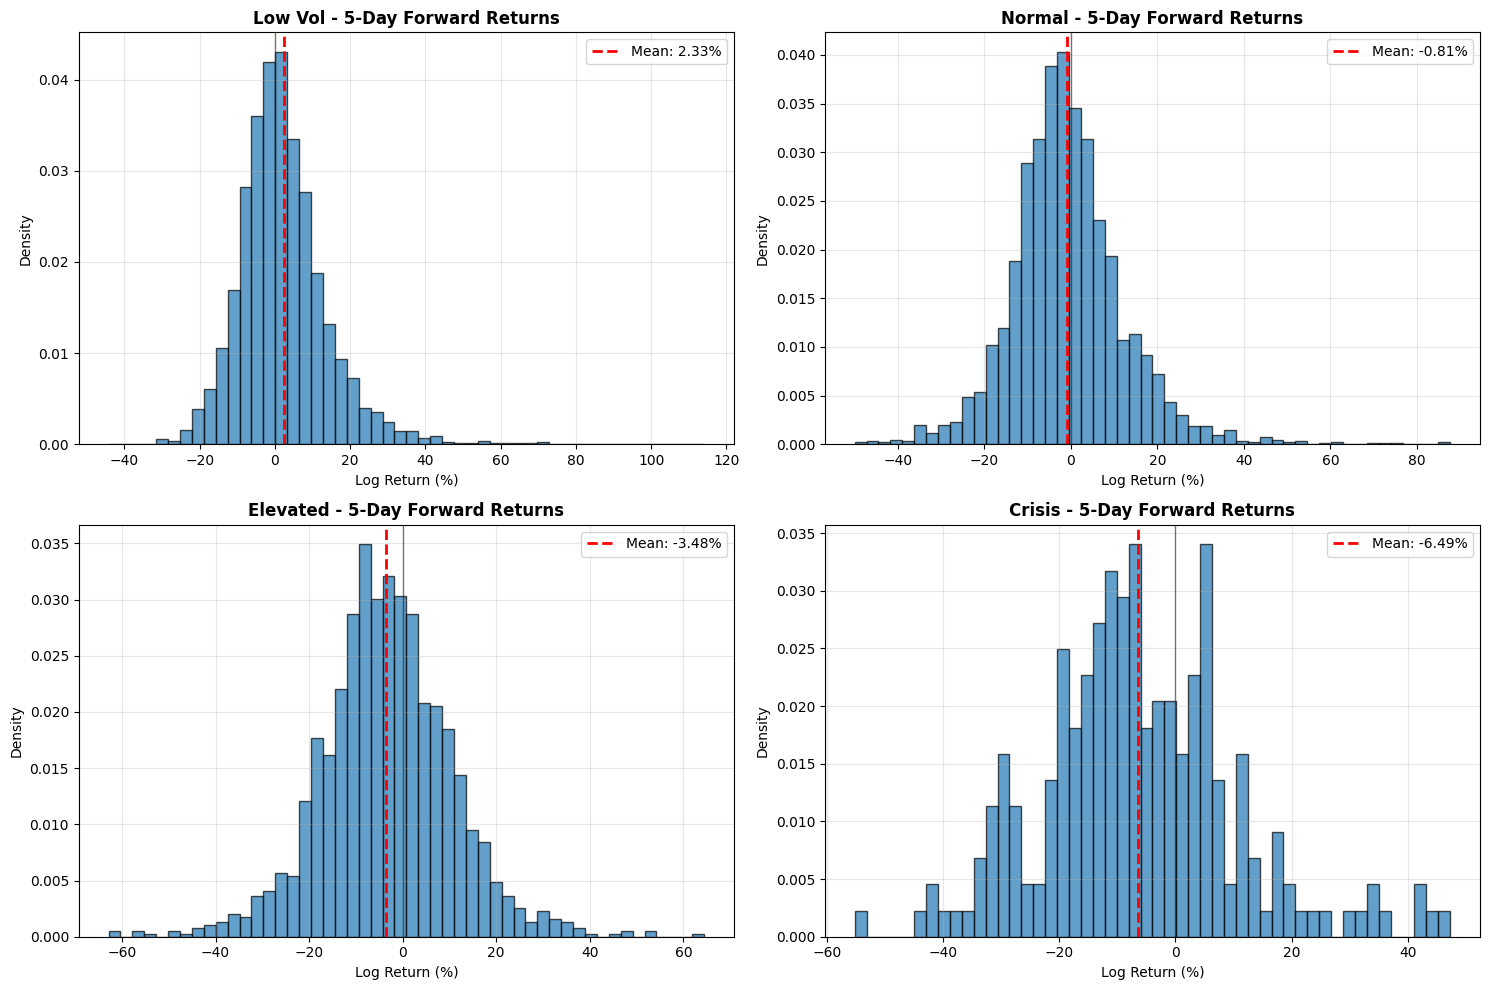


RECOMMENDED FEATURES FOR YOUR XGBOOST MODEL

REGIME-BASED FEATURES:
1. Current regime (categorical)
2. Days in current regime (persistence)
3. Distance to nearest regime boundary
4. VIX percentile rank within current regime
5. Regime transition probability (from transition matrix)

STATISTICAL FEATURES BY REGIME:
6. Rolling volatility of VIX (20d, calibrated by regime)
7. Mean reversion z-score within regime
8. Skewness of recent returns (5d, 20d) - varies by regime
9. Distance from regime mean/median

INTERACTION FEATURES:
10. Regime × Day-of-week
11. Regime × FOMC week indicator
12. Regime × OpEx week indicator
13. Regime × Earnings season indicator
14. Regime × Time-to-FOMC (days)

VOLATILITY CLUSTERING:
15. Vol-of-vol (20-day rolling std of daily VIX changes)
16. GARCH(1,1) conditional variance estimates by regime
17. High-low range percentile within regime

TERM STRUCTURE (if available):
18. VIX/VIX3M ratio
19. VIX/VIX6M ratio
20. Term structure slope change

MEAN REVERSION INDIC

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
from scipy import stats
from scipy.stats import skew, kurtosis

# Fetch VIX data
print("Fetching VIX data...")
vix_data = yf.download("^VIX", start="1990-01-01", end=datetime.today().strftime('%Y-%m-%d'))
vix = vix_data['Close'].squeeze().dropna()

# Calculate 5-day forward returns (your target)
vix_forward_5d = vix.shift(-5)
vix_return_5d = np.log(vix_forward_5d / vix) * 100  # log normalized % change

print("="*80)
print("REGIME-DEPENDENT STATISTICS FOR VIX")
print("="*80)

# Define regimes
def assign_regime(value):
    if value < 16.77:
        return 'Low Vol'
    elif value < 24.40:
        return 'Normal'
    elif value < 39.67:
        return 'Elevated'
    else:
        return 'Crisis'

vix_df = pd.DataFrame({
    'vix': vix,
    'regime': vix.apply(assign_regime),
    'forward_5d_return': vix_return_5d
})

# 1. REGIME TRANSITION PROBABILITIES
print("\n1. REGIME TRANSITION MATRIX (5-day forward)")
print("-"*80)
vix_df['regime_5d_ahead'] = vix_df['regime'].shift(-5)
transition_matrix = pd.crosstab(
    vix_df['regime'], 
    vix_df['regime_5d_ahead'], 
    normalize='index'
) * 100
print(transition_matrix.round(2))
print("\nInterpretation: Shows probability of moving from one regime to another in 5 days")

# 2. MEAN REVERSION BY REGIME
print("\n2. MEAN REVERSION STATISTICS BY REGIME")
print("-"*80)
for regime in ['Low Vol', 'Normal', 'Elevated', 'Crisis']:
    regime_data = vix_df[vix_df['regime'] == regime]['forward_5d_return'].dropna()
    if len(regime_data) > 0:
        print(f"\n{regime}:")
        print(f"  Mean 5d return: {regime_data.mean():.3f}%")
        print(f"  Median 5d return: {regime_data.median():.3f}%")
        print(f"  Std Dev: {regime_data.std():.3f}%")
        print(f"  % Positive: {(regime_data > 0).sum() / len(regime_data) * 100:.1f}%")
        print(f"  % Negative: {(regime_data < 0).sum() / len(regime_data) * 100:.1f}%")
        
        # Mean reversion indicator
        if regime_data.mean() < -1:
            print(f"  >> STRONG MEAN REVERSION (tends to decrease)")
        elif regime_data.mean() > 1:
            print(f"  >> MOMENTUM (tends to increase)")

# 3. VOLATILITY OF VOLATILITY (vol clustering)
print("\n3. VOLATILITY OF VOLATILITY BY REGIME")
print("-"*80)
vix_df['vix_pct_change'] = vix.pct_change() * 100
vix_df['vol_of_vol_20d'] = vix_df['vix_pct_change'].rolling(20).std()

for regime in ['Low Vol', 'Normal', 'Elevated', 'Crisis']:
    regime_vol = vix_df[vix_df['regime'] == regime]['vol_of_vol_20d'].dropna()
    if len(regime_vol) > 0:
        print(f"{regime}: Mean Vol-of-Vol = {regime_vol.mean():.2f}, Median = {regime_vol.median():.2f}")

# 4. DISTANCE FROM REGIME BOUNDARIES (key feature!)
print("\n4. DISTANCE FROM REGIME BOUNDARIES")
print("-"*80)
print("Feature idea: How close is VIX to transitioning to next regime?")

def distance_to_boundaries(value):
    boundaries = [16.77, 24.40, 39.67]
    distances = {
        'dist_to_normal': abs(value - 16.77),
        'dist_to_elevated': abs(value - 24.40),
        'dist_to_crisis': abs(value - 39.67),
        'min_boundary_dist': min(abs(value - b) for b in boundaries)
    }
    return distances

sample_vix = [12, 16, 20, 28, 45]
for v in sample_vix:
    dist = distance_to_boundaries(v)
    print(f"VIX={v}: Min distance to boundary = {dist['min_boundary_dist']:.2f}")

# 5. REGIME DURATION STATISTICS
print("\n5. REGIME PERSISTENCE (How long do regimes last?)")
print("-"*80)
vix_df['regime_change'] = vix_df['regime'] != vix_df['regime'].shift(1)
vix_df['regime_duration'] = vix_df.groupby((vix_df['regime_change']).cumsum()).cumcount() + 1

for regime in ['Low Vol', 'Normal', 'Elevated', 'Crisis']:
    # Get duration at regime exit points
    regime_exits = vix_df[(vix_df['regime'] == regime) & (vix_df['regime_change'].shift(-1) == True)]
    if len(regime_exits) > 0:
        durations = regime_exits['regime_duration']
        print(f"\n{regime}:")
        print(f"  Median duration: {durations.median():.0f} days")
        print(f"  Mean duration: {durations.mean():.0f} days")
        print(f"  Max duration: {durations.max():.0f} days")

# 6. SKEWNESS AND KURTOSIS BY REGIME
print("\n6. DISTRIBUTION CHARACTERISTICS BY REGIME")
print("-"*80)
for regime in ['Low Vol', 'Normal', 'Elevated', 'Crisis']:
    regime_returns = vix_df[vix_df['regime'] == regime]['forward_5d_return'].dropna()
    if len(regime_returns) > 10:
        print(f"\n{regime}:")
        print(f"  Skewness: {skew(regime_returns):.3f}")
        print(f"  Kurtosis: {kurtosis(regime_returns):.3f}")
        print(f"  95th percentile: {np.percentile(regime_returns, 95):.2f}%")
        print(f"  5th percentile: {np.percentile(regime_returns, 5):.2f}%")

# 7. VIX SPIKE PROBABILITY
print("\n7. VIX SPIKE ANALYSIS (>20% increase in 5 days)")
print("-"*80)
vix_df['spike'] = vix_df['forward_5d_return'] > 20
for regime in ['Low Vol', 'Normal', 'Elevated', 'Crisis']:
    regime_data = vix_df[vix_df['regime'] == regime]
    if len(regime_data) > 0:
        spike_prob = regime_data['spike'].sum() / len(regime_data) * 100
        print(f"{regime}: {spike_prob:.2f}% chance of >20% spike in next 5 days")

# 8. VIX TERM STRUCTURE FEATURES (if you have VIX futures data)
print("\n8. CONTANGO/BACKWARDATION INDICATORS")
print("-"*80)
print("Recommended features if you have VIX futures:")
print("  - VIX/VIX3M ratio (term structure slope)")
print("  - VIX/VVIX ratio (volatility of volatility)")
print("  - VIX percentile rank within current regime")

# 9. PERCENTILE RANK WITHIN REGIME
print("\n9. VIX PERCENTILE RANK WITHIN CURRENT REGIME")
print("-"*80)
for regime in ['Low Vol', 'Normal', 'Elevated', 'Crisis']:
    regime_vix = vix[vix_df['regime'] == regime]
    if len(regime_vix) > 0:
        print(f"\n{regime} range: {regime_vix.min():.2f} - {regime_vix.max():.2f}")
        print(f"  25th percentile: {regime_vix.quantile(0.25):.2f}")
        print(f"  75th percentile: {regime_vix.quantile(0.75):.2f}")
        print(f"  >> Feature: (current_vix - regime_min) / (regime_max - regime_min)")

# 10. AUTOCORRELATION BY REGIME
print("\n10. AUTOCORRELATION STRUCTURE BY REGIME")
print("-"*80)
for regime in ['Low Vol', 'Normal', 'Elevated', 'Crisis']:
    regime_returns = vix_df[vix_df['regime'] == regime]['vix_pct_change'].dropna()
    if len(regime_returns) > 20:
        acf_1 = regime_returns.autocorr(lag=1)
        acf_5 = regime_returns.autocorr(lag=5)
        print(f"{regime}: ACF(1)={acf_1:.3f}, ACF(5)={acf_5:.3f}")

# 11. REALIZED VOLATILITY VS IMPLIED (VIX)
print("\n11. REALIZED VS IMPLIED VOLATILITY GAP")
print("-"*80)
vix_df['realized_vol_20d'] = vix_df['vix_pct_change'].rolling(20).std() * np.sqrt(252)
vix_df['vix_premium'] = vix_df['vix'] - vix_df['realized_vol_20d']

for regime in ['Low Vol', 'Normal', 'Elevated', 'Crisis']:
    regime_premium = vix_df[vix_df['regime'] == regime]['vix_premium'].dropna()
    if len(regime_premium) > 0:
        print(f"{regime}: Mean VIX premium = {regime_premium.mean():.2f}")

# VISUALIZATION: Regime-dependent return distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
regimes = ['Low Vol', 'Normal', 'Elevated', 'Crisis']

for idx, (regime, ax) in enumerate(zip(regimes, axes.flatten())):
    regime_returns = vix_df[vix_df['regime'] == regime]['forward_5d_return'].dropna()
    
    if len(regime_returns) > 10:
        ax.hist(regime_returns, bins=50, alpha=0.7, edgecolor='black', density=True)
        ax.axvline(regime_returns.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {regime_returns.mean():.2f}%')
        ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
        ax.set_title(f'{regime} - 5-Day Forward Returns', fontsize=12, fontweight='bold')
        ax.set_xlabel('Log Return (%)')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# FEATURE ENGINEERING RECOMMENDATIONS
print("\n" + "="*80)
print("RECOMMENDED FEATURES FOR YOUR XGBOOST MODEL")
print("="*80)
print("""
REGIME-BASED FEATURES:
1. Current regime (categorical)
2. Days in current regime (persistence)
3. Distance to nearest regime boundary
4. VIX percentile rank within current regime
5. Regime transition probability (from transition matrix)

STATISTICAL FEATURES BY REGIME:
6. Rolling volatility of VIX (20d, calibrated by regime)
7. Mean reversion z-score within regime
8. Skewness of recent returns (5d, 20d) - varies by regime
9. Distance from regime mean/median

INTERACTION FEATURES:
10. Regime × Day-of-week
11. Regime × FOMC week indicator
12. Regime × OpEx week indicator
13. Regime × Earnings season indicator
14. Regime × Time-to-FOMC (days)

VOLATILITY CLUSTERING:
15. Vol-of-vol (20-day rolling std of daily VIX changes)
16. GARCH(1,1) conditional variance estimates by regime
17. High-low range percentile within regime

TERM STRUCTURE (if available):
18. VIX/VIX3M ratio
19. VIX/VIX6M ratio
20. Term structure slope change

MEAN REVERSION INDICATORS:
21. (VIX - regime MA) / regime StdDev
22. Days since regime peak/trough
23. Regime momentum (5d return within regime context)

CALENDAR ANOMALIES INTERACTED WITH REGIME:
24. Is Monday × Regime
25. Is Friday × Regime
26. Days to month-end × Regime
27. Quarter-end week × Regime
""")

print("\nKEY INSIGHT: Your model should learn that:")
print("  - Low Vol → High spike probability, mean reversion upward")
print("  - Crisis → High reversion probability, mean reversion downward")
print("  - Regime boundaries are sticky (clustering)")
print("  - Volatility clustering is regime-dependent")

In [8]:
# In your notebook or test script
from core.regime_classifier import RegimeClassifier

classifier = RegimeClassifier()

# Test on known date
test_date = pd.Timestamp('2020-03-15')  # COVID spike
vix_value = 30.5

# Get features
features = classifier.compute_regime_statistical_features(vix_value)
print(features)

# Verify: All values should be historical statistics, not predictions
# regime_expected_return_5d should be -3.475 (Elevated regime historical mean)
# NOT the actual future return on 2020-03-20

# After integration, test feature build
from core.feature_engineer import FeatureEngineer
from core.data_fetcher import UnifiedDataFetcher

fetcher = UnifiedDataFetcher()
engineer = FeatureEngineer(fetcher)

data = engineer.build_complete_features(years=20, end_date='2024-12-31')
features = data['features']

# Check regime features exist
regime_cols = [c for c in features.columns if 'regime' in c.lower()]
print(f"Found {len(regime_cols)} regime features:")
print(regime_cols)

# Verify no NaNs in recent data
recent = features.iloc[-100:]
print("\nNaN counts in recent 100 days:")
print(recent[regime_cols].isna().sum())

{'regime_expected_return_5d': -3.475, 'regime_median_return_5d': -3.787, 'regime_return_std_5d': 14.13, 'regime_prob_up_5d': 0.38, 'regime_vol_of_vol': 7.44, 'regime_spike_prob': 0.0437}

🏗️  Building 20y feature set | Temporal Safety: ON
Mode: HISTORICAL
Date Ranges: Warmup Start -> Warmup End (usable period) -> Training End Date: 2003-10-13 → 2005-01-05 → 2024-12-31


17:35:54 [WARNING] FRED:CPIAUCSL: Fetch failed, using existing cache - 400 Client Error: Bad Request for url: https://api.stlouisfed.org/fred/series/observations?series_id



✅ Complete: 259 features | 5341 rows
   Date range: 2003-10-13 → 2024-12-31

Found 32 regime features:
['vix_regime', 'days_in_regime', 'regime_distance_to_boundary', 'regime_within_regime_percentile', 'regime_change_flag', 'time_in_regime_pct', 'regime_expected_return_5d', 'regime_median_return_5d', 'regime_return_std_5d', 'regime_prob_up_5d', 'regime_vol_of_vol', 'regime_spike_prob', 'regime_prob_stay', 'regime_prob_crisis', 'regime_prob_elevated', 'rsi_regime', 'skew_regime', 'bond_vol_regime', 'cboe_stress_regime', 'vx_term_structure_regime', 'oil_term_regime', 'vol_of_vol_regime', 'vix_regime_micro', 'regime_transition_risk', 'vol_regime', 'risk_premium_regime', 'vol_term_regime', 'trend_regime', 'liquidity_regime', 'correlation_regime', 'vix_momentum_regime', 'SKEW_momentum_regime']

NaN counts in recent 100 days:
vix_regime                         0
days_in_regime                     0
regime_distance_to_boundary        0
regime_within_regime_percentile    0
regime_change_flag 

In [1]:
import sys;sys.path.append('/home/claude')
import sqlite3,pandas as pd,numpy as np
from pathlib import Path
from datetime import datetime
pd.set_option('display.max_rows',None);pd.set_option('display.max_columns',None);pd.set_option('display.width',None)

# Ensemble config from config.py
ENSEMBLE_CONFIG={"enabled":True,"reconciliation_method":"weighted_agreement","confidence_weights":{"magnitude":0.3725,"direction":0.5146,"agreement":0.2344},"magnitude_thresholds":{"small":1.5105,"medium":5.5140,"large":14.1987},"agreement_bonus":{"strong":0.1865,"moderate":0.0846,"weak":0.0},"contradiction_penalty":{"severe":0.2095,"moderate":0.1252,"minor":0.0370},"min_ensemble_confidence":0.50,"actionable_threshold":0.65}

def compute_ensemble_confidence(magnitude_pct,direction_prob):
    """Replicate the exact ensemble logic from xgboost_trainer_v3.py"""
    cfg=ENSEMBLE_CONFIG;weights=cfg["confidence_weights"];thresholds=cfg["magnitude_thresholds"];agreement_bonus=cfg["agreement_bonus"];contradiction_penalty=cfg["contradiction_penalty"]
    abs_mag=abs(magnitude_pct);mag_conf=0.5+min(abs_mag/thresholds["large"],0.5)*0.5;dir_conf=max(direction_prob,1-direction_prob);predicted_up=direction_prob>0.5;magnitude_up=magnitude_pct>0;models_agree=predicted_up==magnitude_up
    if models_agree:
        if abs_mag>thresholds["medium"]and dir_conf>0.75:agreement_score=agreement_bonus["strong"]
        elif abs_mag>thresholds["small"]and dir_conf>0.65:agreement_score=agreement_bonus["moderate"]
        else:agreement_score=agreement_bonus["weak"]
    else:
        if abs_mag>thresholds["medium"]and dir_conf>0.75:agreement_score=-contradiction_penalty["severe"]
        elif abs_mag>thresholds["small"]and dir_conf>0.65:agreement_score=-contradiction_penalty["moderate"]
        else:agreement_score=-contradiction_penalty["minor"]
    ensemble_conf=weights["magnitude"]*mag_conf+weights["direction"]*dir_conf+weights["agreement"]*(0.5+agreement_score);ensemble_conf=np.clip(ensemble_conf,cfg["min_ensemble_confidence"],1.0)
    return float(ensemble_conf)

def load_database(db_path):
    conn=sqlite3.connect(db_path);query="SELECT * FROM forecasts ORDER BY forecast_date";df=pd.read_sql_query(query,conn,parse_dates=['observation_date','forecast_date','timestamp']);conn.close();return df

def analyze_ensemble_patterns(df):
    print("="*100);print("🎯 ENSEMBLE CONFIDENCE ANALYSIS (Actual System Logic)");print("="*100)
    df=df[df['direction_probability'].notna()&df['magnitude_forecast'].notna()].copy()
    df['ensemble_confidence']=df.apply(lambda row:compute_ensemble_confidence(row['magnitude_forecast'],row['direction_probability']),axis=1)
    df['magnitude_confidence']=df['magnitude_forecast'].apply(lambda x:0.5+min(abs(x)/ENSEMBLE_CONFIG["magnitude_thresholds"]["large"],0.5)*0.5)
    df['direction_confidence']=df['direction_probability'].apply(lambda x:max(x,1-x))
    df['models_agree']=((df['direction_probability']>0.5)==(df['magnitude_forecast']>0))
    df['vix_regime']=pd.cut(df['current_vix'],bins=[0,15,20,25,100],labels=['Low (<15)','Normal (15-20)','Elevated (20-25)','High (>25)'])
    total=len(df);actionable=df[df['ensemble_confidence']>=0.65];n_actionable=len(actionable);pct_actionable=(n_actionable/total)*100 if total>0 else 0
    print(f"\n1️⃣ ACTUAL ACTIONABLE SIGNAL FREQUENCY (Ensemble ≥65%)")
    print(f"   Total Predictions: {total}")
    print(f"   Actionable (≥65%): {n_actionable} ({pct_actionable:.1f}%)")
    print(f"   Below Threshold:   {total-n_actionable} ({100-pct_actionable:.1f}%)")
    print(f"\n   Comparison:")
    print(f"   Raw Direction ≥65%: {len(df[df['direction_confidence']>=0.65])} ({len(df[df['direction_confidence']>=0.65])/total*100:.1f}%)")
    print(f"   Ensemble ≥65%:      {n_actionable} ({pct_actionable:.1f}%)")
    print(f"\n2️⃣ ENSEMBLE CONFIDENCE DISTRIBUTION")
    bins=[0.5,0.55,0.60,0.65,0.70,0.75,0.80,1.0];labels=['50-55%','55-60%','60-65%','65-70%','70-75%','75-80%','80+%'];df['ens_bucket']=pd.cut(df['ensemble_confidence'],bins=bins,labels=labels);dist=df['ens_bucket'].value_counts().sort_index()
    for bucket in labels:
        count=dist.get(bucket,0);pct=(count/total)*100 if total>0 else 0;is_actionable="✅" if bucket>='65-70%' else "  ";print(f"   {is_actionable} {bucket}: {count:4d} ({pct:5.1f}%)")
    print(f"\n3️⃣ MODEL AGREEMENT IMPACT")
    agree_stats=df.groupby('models_agree').agg({'ensemble_confidence':['count','mean','std'],'direction_confidence':'mean','magnitude_confidence':'mean'}).round(3)
    print(f"   Models AGREE:    {int(agree_stats.loc[True,('ensemble_confidence','count')]):4d} preds | Ens Conf: {agree_stats.loc[True,('ensemble_confidence','mean')]:.3f} | Dir: {agree_stats.loc[True,('direction_confidence','mean')]:.3f} | Mag: {agree_stats.loc[True,('magnitude_confidence','mean')]:.3f}")
    print(f"   Models DISAGREE: {int(agree_stats.loc[False,('ensemble_confidence','count')]):4d} preds | Ens Conf: {agree_stats.loc[False,('ensemble_confidence','mean')]:.3f} | Dir: {agree_stats.loc[False,('direction_confidence','mean')]:.3f} | Mag: {agree_stats.loc[False,('magnitude_confidence','mean')]:.3f}")
    actionable_agree=len(df[(df['ensemble_confidence']>=0.65)&(df['models_agree']==True)]);actionable_disagree=len(df[(df['ensemble_confidence']>=0.65)&(df['models_agree']==False)])
    print(f"   Actionable when AGREE: {actionable_agree} | DISAGREE: {actionable_disagree}")
    print(f"\n4️⃣ ENSEMBLE CONFIDENCE BY VIX REGIME")
    regime_stats=df.groupby('vix_regime').agg({'ensemble_confidence':['count','mean','std'],'current_vix':'mean','models_agree':'mean'}).round(3)
    for regime in['Low (<15)','Normal (15-20)','Elevated (20-25)','High (>25)']:
        if regime in regime_stats.index:
            count=int(regime_stats.loc[regime,('ensemble_confidence','count')]);mean_conf=regime_stats.loc[regime,('ensemble_confidence','mean')];std_conf=regime_stats.loc[regime,('ensemble_confidence','std')];mean_vix=regime_stats.loc[regime,('current_vix','mean')];agree_pct=regime_stats.loc[regime,('models_agree','mean')]*100;pct_actionable_regime=(df[(df['vix_regime']==regime)&(df['ensemble_confidence']>=0.65)].shape[0]/count)*100 if count>0 else 0;print(f"   {regime:20s}: {count:4d} preds | Ens: {mean_conf:.3f} ± {std_conf:.3f} | VIX: {mean_vix:.1f} | Agree: {agree_pct:.0f}% | {pct_actionable_regime:.1f}% actionable")
    if n_actionable>0:
        print(f"\n5️⃣ ACTIONABLE SIGNALS (Ensemble ≥65%)")
        actionable_sorted=actionable.sort_values('forecast_date',ascending=False)[['forecast_date','current_vix','direction_prediction','direction_probability','direction_confidence','magnitude_forecast','magnitude_confidence','ensemble_confidence','models_agree','actual_vix_change','direction_correct']];print(f"   Most Recent 20 Actionable Signals:");print(actionable_sorted.head(20).to_string(index=False))
        if 'actual_vix_change' in actionable.columns and actionable['actual_vix_change'].notna().sum()>0:
            with_actuals=actionable[actionable['actual_vix_change'].notna()];acc=with_actuals['direction_correct'].mean();n_with_actuals=len(with_actuals);print(f"\n   Accuracy When Actionable: {acc:.1%} ({n_with_actuals} signals with outcomes)")
    print(f"\n6️⃣ CONFIDENCE BREAKDOWN (Most Recent Forecast)")
    recent=df.sort_values('forecast_date',ascending=False).head(1)
    if len(recent)>0:
        latest=recent.iloc[0];print(f"   Date:                {latest['forecast_date']}")
        print(f"   VIX:                 {latest['current_vix']:.2f}")
        print(f"   Direction:           {latest['direction_prediction']}")
        print(f"   Magnitude:           {latest['magnitude_forecast']:+.2f}%")
        print(f"   Models Agree:        {'✓ YES' if latest['models_agree'] else '✗ NO'}")
        print(f"\n   Component Confidences:")
        print(f"     Magnitude:         {latest['magnitude_confidence']:.1%}")
        print(f"     Direction:         {latest['direction_confidence']:.1%}")
        print(f"     Ensemble:          {latest['ensemble_confidence']:.1%}")
        print(f"\n   Status:              {'✅ ACTIONABLE' if latest['ensemble_confidence']>=0.65 else '🟡 BELOW THRESHOLD (65%)'}")
    print(f"\n7️⃣ TREND OVER TIME (Monthly Ensemble Confidence)")
    df['year_month']=pd.to_datetime(df['forecast_date']).dt.to_period('M');monthly=df.groupby('year_month').agg({'ensemble_confidence':'mean','direction_confidence':'mean','magnitude_confidence':'mean','current_vix':'mean','models_agree':'mean'}).tail(12)
    print(monthly.to_string())
    print("="*100)

if __name__=="__main__":
    possible_paths=[Path.home()/"Desktop/GitHub/SPX_Analysis/src/data_cache/predictions.db",Path.home()/"Desktop/GitHub/SPX_Analysis/data_cache/predictions.db",Path("data_cache/predictions.db"),Path("../data_cache/predictions.db")]
    db_path=None
    for path in possible_paths:
        if path.exists():db_path=path;break
    if db_path is None:print(f"❌ Database not found");[print(f"   - {p}")for p in possible_paths];sys.exit(1)
    print(f"Loading database: {db_path}");df=load_database(db_path);print(f"Loaded {len(df)} predictions\n");analyze_ensemble_patterns(df)

Loading database: /Users/johnluo/Desktop/GitHub/SPX_Analysis/src/data_cache/predictions.db
Loaded 269 predictions

🎯 ENSEMBLE CONFIDENCE ANALYSIS (Actual System Logic)

1️⃣ ACTUAL ACTIONABLE SIGNAL FREQUENCY (Ensemble ≥65%)
   Total Predictions: 269
   Actionable (≥65%): 176 (65.4%)
   Below Threshold:   93 (34.6%)

   Comparison:
   Raw Direction ≥65%: 80 (29.7%)
   Ensemble ≥65%:      176 (65.4%)

2️⃣ ENSEMBLE CONFIDENCE DISTRIBUTION
      50-55%:    0 (  0.0%)
      55-60%:   26 (  9.7%)
      60-65%:   67 ( 24.9%)
   ✅ 65-70%:   95 ( 35.3%)
   ✅ 70-75%:   30 ( 11.2%)
   ✅ 75-80%:   24 (  8.9%)
   ✅ 80+%:   27 ( 10.0%)

3️⃣ MODEL AGREEMENT IMPACT
   Models AGREE:     182 preds | Ens Conf: 0.703 | Dir: 0.642 | Mag: 0.660
   Models DISAGREE:   87 preds | Ens Conf: 0.650 | Dir: 0.606 | Mag: 0.624
   Actionable when AGREE: 128 | DISAGREE: 48

4️⃣ ENSEMBLE CONFIDENCE BY VIX REGIME
   Low (<15)           :   36 preds | Ens: 0.684 ± 0.083 | VIX: 14.3 | Agree: 81% | 75.0% actionable
   Norm

/var/folders/x7/wx6vsrv14yb8t8zyw52zj5r80000gn/T/ipykernel_77954/142829362.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  regime_stats=df.groupby('vix_regime').agg({'ensemble_confidence':['count','mean','std'],'current_vix':'mean','models_agree':'mean'}).round(3)


In [24]:
import pandas as pd
import requests
from datetime import datetime, timedelta
from io import StringIO
import os

MONTH_CODES = {
    1: 'F', 2: 'G', 3: 'H', 4: 'J', 5: 'K', 6: 'M',
    7: 'N', 8: 'Q', 9: 'U', 10: 'V', 11: 'X', 12: 'Z'
}

def third_friday(year, month):
    """Get the third Friday of a given month"""
    first_day = datetime(year, month, 1)
    days_until_friday = (4 - first_day.weekday()) % 7
    first_friday = first_day + timedelta(days=days_until_friday)
    return first_friday + timedelta(days=14)

def vix_expiration(year, month):
    """Calculate VIX futures expiration date for a given month"""
    next_month = month + 1
    next_year = year
    if next_month > 12:
        next_month = 1
        next_year += 1
    
    third_fri = third_friday(next_year, next_month)
    expiration = third_fri - timedelta(days=30)
    return expiration

def get_active_contracts_for_date(target_date):
    """Determine which contracts were VX1 and VX2 on a specific historical date
    TradingView rolls contracts 1 day BEFORE expiration (not on expiration day)"""
    # Generate contracts starting from a few months before target date
    year, month = target_date.year, target_date.month - 3
    if month <= 0:
        month += 12
        year -= 1
    
    contracts = []
    for _ in range(15):  # Generate enough contracts
        exp_date = vix_expiration(year, month)
        
        # Include contracts that expire AFTER the target date
        # TradingView rolls 1 day before expiration, so on expiry day the contract is already rolled
        if exp_date.date() > target_date:
            month_code = MONTH_CODES[month]
            year_code = str(year)[-1]
            contract_code = f"{month_code}{year_code}"
            
            contracts.append({
                'code': contract_code,
                'expiration': exp_date,
                'month': month,
                'year': year
            })
        
        month += 1
        if month > 12:
            month = 1
            year += 1
    
    # Return first two unexpired contracts (VX1 and VX2)
    return contracts[:2] if len(contracts) >= 2 else None

def fetch_vix_data_for_date(contract_exp_date, target_date):
    """Fetch VIX futures data for a specific contract and date"""
    url = f"https://cdn.cboe.com/data/us/futures/market_statistics/historical_data/VX/VX_{contract_exp_date.strftime('%Y-%m-%d')}.csv"
    
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        df = pd.read_csv(StringIO(response.text))
        
        if df.empty:
            return None
        
        # Convert Trade Date to datetime for comparison
        df['Trade Date'] = pd.to_datetime(df['Trade Date'])
        target_dt = pd.to_datetime(target_date)
        
        # Find the row for the specific date
        date_data = df[df['Trade Date'] == target_dt]
        
        if date_data.empty:
            return None
        
        row = date_data.iloc[0]
        return {
            'date': row['Trade Date'].strftime('%Y-%m-%d'),
            'open': float(row['Open']),
            'high': float(row['High']),
            'low': float(row['Low']),
            'close': float(row['Close']),
            'settle': float(row['Settle'])
        }
    except Exception as e:
        return None

def get_missing_dates(csv_path):
    """Identify missing dates between last entry and today"""
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV file not found: {csv_path}")
    
    df = pd.read_csv(csv_path)
    df['Date'] = pd.to_datetime(df['Date'])
    
    last_date = df['Date'].max().date()
    today = datetime.now().date()
    
    # Generate all business days between last date and today (exclusive of last_date)
    missing_dates = []
    current = last_date + timedelta(days=1)
    
    while current <= today:
        # Only include weekdays (Mon-Fri: 0-4)
        if current.weekday() < 5:
            missing_dates.append(current)
        current += timedelta(days=1)
    
    return missing_dates, df

def backfill_vix_spread(csv_path):
    """Backfill missing VIX spread data"""
    print("=" * 70)
    print("VIX FUTURES SPREAD BACKFILLER")
    print("=" * 70)
    
    # Get missing dates
    missing_dates, existing_df = get_missing_dates(csv_path)
    
    if not missing_dates:
        print("\n✓ No missing dates - data is up to date!")
        return
    
    print(f"\nFound {len(missing_dates)} missing dates")
    print(f"Range: {missing_dates[0]} to {missing_dates[-1]}")
    print(f"\nStarting backfill...\n")
    
    new_rows = []
    successful = 0
    failed_dates = []
    
    for target_date in missing_dates:
        print(f"Processing {target_date}...", end=" ")
        
        # Determine which contracts were active on this date
        contracts = get_active_contracts_for_date(target_date)
        
        if not contracts or len(contracts) < 2:
            print("❌ Could not determine contracts")
            failed_dates.append(target_date)
            continue
        
        vx1, vx2 = contracts[0], contracts[1]
        
        # Fetch data for both contracts
        vx1_data = fetch_vix_data_for_date(vx1['expiration'], target_date)
        vx2_data = fetch_vix_data_for_date(vx2['expiration'], target_date)
        
        if vx1_data and vx2_data:
            # Calculate spread as VX2-VX1 (back minus front) to match Pine logs
            spread_open = vx2_data['open'] - vx1_data['open']
            spread_high = vx2_data['high'] - vx1_data['high']
            spread_low = vx2_data['low'] - vx1_data['low']
            spread_close = vx2_data['settle'] - vx1_data['settle']  # Use settle for close
            
            new_rows.append({
                'Date': target_date.strftime('%Y-%m-%d'),
                'Open': round(spread_open, 4),
                'High': round(spread_high, 4),
                'Low': round(spread_low, 4),
                'Close': round(spread_close, 4)
            })
            
            print(f"✓ {vx1['code']}-{vx2['code']}: {spread_close:.4f}")
            successful += 1
        else:
            print(f"❌ No data available")
            failed_dates.append(target_date)
    
    # Append new data to CSV
    if new_rows:
        new_df = pd.DataFrame(new_rows)
        combined_df = pd.concat([existing_df, new_df], ignore_index=True)
        combined_df['Date'] = pd.to_datetime(combined_df['Date'])
        combined_df = combined_df.sort_values('Date')
        combined_df['Date'] = combined_df['Date'].dt.strftime('%Y-%m-%d')
        
        combined_df.to_csv(csv_path, index=False)
        
        print(f"\n{'='*70}")
        print(f"SUMMARY")
        print(f"{'='*70}")
        print(f"Successfully added: {successful} dates")
        print(f"Failed: {len(failed_dates)} dates")
        if failed_dates:
            print(f"Failed dates: {', '.join([str(d) for d in failed_dates[:5]])}")
            if len(failed_dates) > 5:
                print(f"  ... and {len(failed_dates)-5} more")
        print(f"\n✓ Data saved to {csv_path}")
    else:
        print("\n⚠ No new data to add")

if __name__ == "__main__":
    # Set your file path here
    csv_path = os.path.expanduser("~/Desktop/GitHub/SPX_Analysis/src/CBOE_Data_Archive/VX1-VX2.csv")
    
    try:
        backfill_vix_spread(csv_path)
    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()

VIX FUTURES SPREAD BACKFILLER

Found 17 missing dates
Range: 2025-11-03 to 2025-11-25

Starting backfill...

Processing 2025-11-03... ✓ X5-Z5: 0.9598
Processing 2025-11-04... ✓ X5-Z5: 0.7420
Processing 2025-11-05... ✓ X5-Z5: 0.8478
Processing 2025-11-06... ✓ X5-Z5: 0.3321
Processing 2025-11-07... ✓ X5-Z5: 0.3501
Processing 2025-11-10... ✓ X5-Z5: 0.7445
Processing 2025-11-11... ✓ X5-Z5: 0.9181
Processing 2025-11-12... ✓ X5-Z5: 1.0613
Processing 2025-11-13... ✓ X5-Z5: 0.0931
Processing 2025-11-14... ✓ X5-Z5: 0.0510
Processing 2025-11-17... ✓ X5-Z5: -0.8805
Processing 2025-11-18... ✓ X5-Z5: -2.1963
Processing 2025-11-19... ✓ Z5-F6: 0.9245
Processing 2025-11-20... ✓ Z5-F6: 0.3536
Processing 2025-11-21... ✓ Z5-F6: 0.8566
Processing 2025-11-24... ✓ Z5-F6: 1.2065
Processing 2025-11-25... ❌ No data available

SUMMARY
Successfully added: 16 dates
Failed: 1 dates
Failed dates: 2025-11-25

✓ Data saved to /Users/johnluo/Desktop/GitHub/SPX_Analysis/src/CBOE_Data_Archive/VX1-VX2.csv


In [26]:
# Run this in a Jupyter Lab cell from the /src directory
import pandas as pd
import requests
from datetime import datetime
import os
from pathlib import Path
import time

# Complete monthly expiration dates from CBOE (2013-2026)
EXPIRATION_DATES = [
    # 2013
    (2013, 1, '2013-01-16'), (2013, 2, '2013-02-13'), (2013, 3, '2013-03-20'), (2013, 4, '2013-04-17'),
    (2013, 5, '2013-05-22'), (2013, 6, '2013-06-19'), (2013, 7, '2013-07-17'), (2013, 8, '2013-08-21'),
    (2013, 9, '2013-09-18'), (2013, 10, '2013-10-16'), (2013, 11, '2013-11-20'), (2013, 12, '2013-12-18'),
    # 2014
    (2014, 1, '2014-01-22'), (2014, 2, '2014-02-19'), (2014, 3, '2014-03-18'), (2014, 4, '2014-04-16'),
    (2014, 5, '2014-05-21'), (2014, 6, '2014-06-18'), (2014, 7, '2014-07-16'), (2014, 8, '2014-08-20'),
    (2014, 9, '2014-09-17'), (2014, 10, '2014-10-22'), (2014, 11, '2014-11-19'), (2014, 12, '2014-12-17'),
    # 2015
    (2015, 1, '2015-01-21'), (2015, 2, '2015-02-18'), (2015, 3, '2015-03-18'), (2015, 4, '2015-04-15'),
    (2015, 5, '2015-05-20'), (2015, 6, '2015-06-17'), (2015, 7, '2015-07-22'), (2015, 8, '2015-08-19'),
    (2015, 9, '2015-09-16'), (2015, 10, '2015-10-21'), (2015, 11, '2015-11-18'), (2015, 12, '2015-12-16'),
    # 2016
    (2016, 1, '2016-01-20'), (2016, 2, '2016-02-17'), (2016, 3, '2016-03-16'), (2016, 4, '2016-04-20'),
    (2016, 5, '2016-05-18'), (2016, 6, '2016-06-15'), (2016, 7, '2016-07-20'), (2016, 8, '2016-08-17'),
    (2016, 9, '2016-09-21'), (2016, 10, '2016-10-19'), (2016, 11, '2016-11-16'), (2016, 12, '2016-12-21'),
    # 2017
    (2017, 1, '2017-01-18'), (2017, 2, '2017-02-15'), (2017, 3, '2017-03-22'), (2017, 4, '2017-04-19'),
    (2017, 5, '2017-05-17'), (2017, 6, '2017-06-21'), (2017, 7, '2017-07-19'), (2017, 8, '2017-08-16'),
    (2017, 9, '2017-09-20'), (2017, 10, '2017-10-18'), (2017, 11, '2017-11-15'), (2017, 12, '2017-12-20'),
    # 2018
    (2018, 1, '2018-01-17'), (2018, 2, '2018-02-14'), (2018, 3, '2018-03-21'), (2018, 4, '2018-04-18'),
    (2018, 5, '2018-05-16'), (2018, 6, '2018-06-20'), (2018, 7, '2018-07-18'), (2018, 8, '2018-08-22'),
    (2018, 9, '2018-09-19'), (2018, 10, '2018-10-17'), (2018, 11, '2018-11-21'), (2018, 12, '2018-12-19'),
    # 2019
    (2019, 1, '2019-01-16'), (2019, 2, '2019-02-13'), (2019, 3, '2019-03-19'), (2019, 4, '2019-04-17'),
    (2019, 5, '2019-05-22'), (2019, 6, '2019-06-19'), (2019, 7, '2019-07-17'), (2019, 8, '2019-08-21'),
    (2019, 9, '2019-09-18'), (2019, 10, '2019-10-16'), (2019, 11, '2019-11-20'), (2019, 12, '2019-12-18'),
    # 2020
    (2020, 1, '2020-01-22'), (2020, 2, '2020-02-19'), (2020, 3, '2020-03-18'), (2020, 4, '2020-04-15'),
    (2020, 5, '2020-05-20'), (2020, 6, '2020-06-17'), (2020, 7, '2020-07-22'), (2020, 8, '2020-08-19'),
    (2020, 9, '2020-09-16'), (2020, 10, '2020-10-21'), (2020, 11, '2020-11-18'), (2020, 12, '2020-12-16'),
    # 2021
    (2021, 1, '2021-01-20'), (2021, 2, '2021-02-17'), (2021, 3, '2021-03-17'), (2021, 4, '2021-04-21'),
    (2021, 5, '2021-05-19'), (2021, 6, '2021-06-16'), (2021, 7, '2021-07-21'), (2021, 8, '2021-08-18'),
    (2021, 9, '2021-09-15'), (2021, 10, '2021-10-20'), (2021, 11, '2021-11-17'), (2021, 12, '2021-12-22'),
    # 2022
    (2022, 1, '2022-01-19'), (2022, 2, '2022-02-16'), (2022, 3, '2022-03-15'), (2022, 4, '2022-04-20'),
    (2022, 5, '2022-05-18'), (2022, 6, '2022-06-15'), (2022, 7, '2022-07-20'), (2022, 8, '2022-08-17'),
    (2022, 9, '2022-09-21'), (2022, 10, '2022-10-19'), (2022, 11, '2022-11-16'), (2022, 12, '2022-12-21'),
    # 2023
    (2023, 1, '2023-01-18'), (2023, 2, '2023-02-15'), (2023, 3, '2023-03-22'), (2023, 4, '2023-04-19'),
    (2023, 5, '2023-05-17'), (2023, 6, '2023-06-21'), (2023, 7, '2023-07-19'), (2023, 8, '2023-08-16'),
    (2023, 9, '2023-09-20'), (2023, 10, '2023-10-18'), (2023, 11, '2023-11-15'), (2023, 12, '2023-12-20'),
    # 2024
    (2024, 1, '2024-01-17'), (2024, 2, '2024-02-14'), (2024, 3, '2024-03-20'), (2024, 4, '2024-04-17'),
    (2024, 5, '2024-05-22'), (2024, 6, '2024-06-18'), (2024, 7, '2024-07-17'), (2024, 8, '2024-08-21'),
    (2024, 9, '2024-09-18'), (2024, 10, '2024-10-16'), (2024, 11, '2024-11-20'), (2024, 12, '2024-12-18'),
    # 2025
    (2025, 1, '2025-01-22'), (2025, 2, '2025-02-19'), (2025, 3, '2025-03-18'), (2025, 4, '2025-04-16'),
    (2025, 5, '2025-05-21'), (2025, 6, '2025-06-18'), (2025, 7, '2025-07-16'), (2025, 8, '2025-08-20'),
    (2025, 9, '2025-09-17'), (2025, 10, '2025-10-22'), (2025, 11, '2025-11-19'), (2025, 12, '2025-12-17'),
    # 2026
    (2026, 1, '2026-01-21'), (2026, 2, '2026-02-18'), (2026, 3, '2026-03-18'), (2026, 4, '2026-04-15'),
    (2026, 5, '2026-05-19'), (2026, 6, '2026-06-17'), (2026, 7, '2026-07-22'), (2026, 8, '2026-08-19'),
]

MONTH_CODES = {
    1: 'F', 2: 'G', 3: 'H', 4: 'J', 5: 'K', 6: 'M',
    7: 'N', 8: 'Q', 9: 'U', 10: 'V', 11: 'X', 12: 'Z'
}

def get_contract_code(year, month):
    """Generate contract code like F3, G4, etc."""
    month_code = MONTH_CODES[month]
    year_code = str(year)[-1]
    return f"{month_code}{year_code}"

def fetch_vix_contract(year, month, expiration_date, output_dir):
    """Fetch a single VIX futures contract from CBOE"""
    contract_code = get_contract_code(year, month)
    url = f"https://cdn.cboe.com/data/us/futures/market_statistics/historical_data/VX/VX_{expiration_date}.csv"
    output_file = output_dir / f"VX_{contract_code}_{expiration_date}.csv"
    
    if output_file.exists():
        print(f"✓ {contract_code} ({expiration_date}) already exists")
        return 'exists'
    
    try:
        response = requests.get(url, timeout=15)
        response.raise_for_status()
        
        if len(response.text) < 100:
            print(f"✗ {contract_code} ({expiration_date}): Empty data")
            return 'empty'
        
        output_file.write_text(response.text)
        print(f"✓ {contract_code} ({expiration_date}): Downloaded")
        return 'success'
        
    except requests.exceptions.HTTPError as e:
        if e.response.status_code == 404:
            print(f"✗ {contract_code} ({expiration_date}): Not found (404)")
            return '404'
        else:
            print(f"✗ {contract_code} ({expiration_date}): HTTP {e.response.status_code}")
            return 'error'
    except Exception as e:
        print(f"✗ {contract_code} ({expiration_date}): {str(e)[:40]}")
        return 'error'

# Main execution
output_dir = Path.home() / "Desktop/GitHub/SPX_Analysis/src/CBOE_VX_ALL"
output_dir.mkdir(parents=True, exist_ok=True)

print("=" * 80)
print("VIX FUTURES DATA FETCHER")
print("=" * 80)
print(f"Output: {output_dir}")
print(f"Contracts: {len(EXPIRATION_DATES)}")
print("=" * 80)

results = {'success': 0, 'exists': 0, '404': 0, 'empty': 0, 'error': 0}

# Group by year
contracts_by_year = {}
for year, month, date in EXPIRATION_DATES:
    if year not in contracts_by_year:
        contracts_by_year[year] = []
    contracts_by_year[year].append((year, month, date))

# Fetch each contract
for year in sorted(contracts_by_year.keys()):
    print(f"\n{'='*80}")
    print(f"YEAR {year} - {len(contracts_by_year[year])} contracts")
    print(f"{'='*80}")
    
    for yr, mo, exp_date in contracts_by_year[year]:
        result = fetch_vix_contract(yr, mo, exp_date, output_dir)
        results[result] += 1
        time.sleep(0.3)  # Be respectful to CBOE servers

# Summary
print(f"\n{'='*80}")
print("SUMMARY")
print(f"{'='*80}")
print(f"✓ Downloaded: {results['success']}")
print(f"✓ Existed: {results['exists']}")
print(f"✗ Not found: {results['404']}")
print(f"✗ Empty: {results['empty']}")
print(f"✗ Errors: {results['error']}")
print(f"\nTotal checked: {sum(results.values())}")
print(f"Files in folder: {len(list(output_dir.glob('*.csv')))}")
print("=" * 80)

2025-11-25 22:37:01,757 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443


VIX FUTURES DATA FETCHER
Output: /Users/johnluo/Desktop/GitHub/SPX_Analysis/src/CBOE_VX_ALL
Contracts: 164

YEAR 2013 - 12 contracts


2025-11-25 22:37:02,002 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2013-01-16.csv HTTP/1.1" 200 933


✓ F3 (2013-01-16): Downloaded


2025-11-25 22:37:02,345 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:02,613 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2013-02-13.csv HTTP/1.1" 200 2418


✓ G3 (2013-02-13): Downloaded


2025-11-25 22:37:02,933 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:03,202 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2013-03-20.csv HTTP/1.1" 200 4258


✓ H3 (2013-03-20): Downloaded


2025-11-25 22:37:03,575 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:03,764 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2013-04-17.csv HTTP/1.1" 200 5683


✓ J3 (2013-04-17): Downloaded


2025-11-25 22:37:04,108 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:04,338 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2013-05-22.csv HTTP/1.1" 200 7600


✓ K3 (2013-05-22): Downloaded


2025-11-25 22:37:04,659 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:04,864 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2013-06-19.csv HTTP/1.1" 200 9211


✓ M3 (2013-06-19): Downloaded


2025-11-25 22:37:05,183 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:05,429 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2013-07-17.csv HTTP/1.1" 200 10821


✓ N3 (2013-07-17): Downloaded


2025-11-25 22:37:05,753 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:06,145 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2013-08-21.csv HTTP/1.1" 200 12947


✓ Q3 (2013-08-21): Downloaded


2025-11-25 22:37:06,471 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:06,738 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2013-09-18.csv HTTP/1.1" 200 14485


✓ U3 (2013-09-18): Downloaded


2025-11-25 22:37:07,065 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:07,328 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2013-10-16.csv HTTP/1.1" 200 15186


✓ V3 (2013-10-16): Downloaded


2025-11-25 22:37:07,645 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:07,878 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2013-11-20.csv HTTP/1.1" 200 16021


✓ X3 (2013-11-20): Downloaded


2025-11-25 22:37:08,211 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:08,495 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2013-12-18.csv HTTP/1.1" 200 15809


✓ Z3 (2013-12-18): Downloaded


2025-11-25 22:37:08,813 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443



YEAR 2014 - 12 contracts


2025-11-25 22:37:09,101 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2014-01-22.csv HTTP/1.1" 200 16227


✓ F4 (2014-01-22): Downloaded


2025-11-25 22:37:09,419 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:09,651 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2014-02-19.csv HTTP/1.1" 200 16034


✓ G4 (2014-02-19): Downloaded


2025-11-25 22:37:10,011 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:10,449 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2014-03-18.csv HTTP/1.1" 200 15978


✓ H4 (2014-03-18): Downloaded


2025-11-25 22:37:10,783 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:11,017 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2014-04-16.csv HTTP/1.1" 200 16161


✓ J4 (2014-04-16): Downloaded


2025-11-25 22:37:11,333 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:11,597 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2014-05-21.csv HTTP/1.1" 200 16065


✓ K4 (2014-05-21): Downloaded


2025-11-25 22:37:11,916 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:12,394 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2014-06-18.csv HTTP/1.1" 200 16047


✓ M4 (2014-06-18): Downloaded


2025-11-25 22:37:12,724 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:13,048 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2014-07-16.csv HTTP/1.1" 200 15941


✓ N4 (2014-07-16): Downloaded


2025-11-25 22:37:13,381 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:13,577 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2014-08-20.csv HTTP/1.1" 200 15938


✓ Q4 (2014-08-20): Downloaded


2025-11-25 22:37:13,903 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:14,159 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2014-09-17.csv HTTP/1.1" 200 15930


✓ U4 (2014-09-17): Downloaded


2025-11-25 22:37:14,478 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:14,798 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2014-10-22.csv HTTP/1.1" 200 16236


✓ V4 (2014-10-22): Downloaded


2025-11-25 22:37:15,134 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:15,430 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2014-11-19.csv HTTP/1.1" 200 16360


✓ X4 (2014-11-19): Downloaded


2025-11-25 22:37:15,749 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:16,072 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2014-12-17.csv HTTP/1.1" 200 16259


✓ Z4 (2014-12-17): Downloaded


2025-11-25 22:37:16,387 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443



YEAR 2015 - 12 contracts


2025-11-25 22:37:16,631 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2015-01-21.csv HTTP/1.1" 200 16453


✓ F5 (2015-01-21): Downloaded


2025-11-25 22:37:16,951 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:17,210 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2015-02-18.csv HTTP/1.1" 200 15942


✓ G5 (2015-02-18): Downloaded


2025-11-25 22:37:17,540 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:17,828 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2015-03-18.csv HTTP/1.1" 200 16023


✓ H5 (2015-03-18): Downloaded


2025-11-25 22:37:18,146 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:18,448 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2015-04-15.csv HTTP/1.1" 200 16116


✓ J5 (2015-04-15): Downloaded


2025-11-25 22:37:18,784 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:19,053 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2015-05-20.csv HTTP/1.1" 200 16146


✓ K5 (2015-05-20): Downloaded


2025-11-25 22:37:19,368 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:19,636 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2015-06-17.csv HTTP/1.1" 200 16092


✓ M5 (2015-06-17): Downloaded


2025-11-25 22:37:19,961 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:20,318 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2015-07-22.csv HTTP/1.1" 200 16001


✓ N5 (2015-07-22): Downloaded


2025-11-25 22:37:20,633 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:20,908 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2015-08-19.csv HTTP/1.1" 200 16010


✓ Q5 (2015-08-19): Downloaded


2025-11-25 22:37:21,251 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:21,478 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2015-09-16.csv HTTP/1.1" 200 15977


✓ U5 (2015-09-16): Downloaded


2025-11-25 22:37:21,793 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:22,065 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2015-10-21.csv HTTP/1.1" 200 16216


✓ V5 (2015-10-21): Downloaded


2025-11-25 22:37:22,379 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:22,620 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2015-11-18.csv HTTP/1.1" 200 16307


✓ X5 (2015-11-18): Downloaded


2025-11-25 22:37:22,941 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:23,147 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2015-12-16.csv HTTP/1.1" 200 16231


✓ Z5 (2015-12-16): Downloaded


2025-11-25 22:37:23,463 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443



YEAR 2016 - 12 contracts


2025-11-25 22:37:23,799 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2016-01-20.csv HTTP/1.1" 200 16359


✓ F6 (2016-01-20): Downloaded


2025-11-25 22:37:24,114 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:24,359 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2016-02-17.csv HTTP/1.1" 200 15823


✓ G6 (2016-02-17): Downloaded


2025-11-25 22:37:24,684 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:25,026 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2016-03-16.csv HTTP/1.1" 200 15926


✓ H6 (2016-03-16): Downloaded


2025-11-25 22:37:25,345 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:25,641 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2016-04-20.csv HTTP/1.1" 200 15949


✓ J6 (2016-04-20): Downloaded


2025-11-25 22:37:25,963 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:26,429 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2016-05-18.csv HTTP/1.1" 200 15942


✓ K6 (2016-05-18): Downloaded


2025-11-25 22:37:26,745 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:26,984 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2016-06-15.csv HTTP/1.1" 200 15852


✓ M6 (2016-06-15): Downloaded


2025-11-25 22:37:27,293 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:27,563 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2016-07-20.csv HTTP/1.1" 200 15852


✓ N6 (2016-07-20): Downloaded


2025-11-25 22:37:27,876 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:28,128 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2016-08-17.csv HTTP/1.1" 200 15918


✓ Q6 (2016-08-17): Downloaded


2025-11-25 22:37:28,438 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:28,767 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2016-09-21.csv HTTP/1.1" 200 16302


✓ U6 (2016-09-21): Downloaded


2025-11-25 22:37:29,084 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:29,602 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2016-10-19.csv HTTP/1.1" 200 16123


✓ V6 (2016-10-19): Downloaded


2025-11-25 22:37:29,919 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:30,139 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2016-11-16.csv HTTP/1.1" 200 16198


✓ X6 (2016-11-16): Downloaded


2025-11-25 22:37:30,456 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:30,693 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2016-12-21.csv HTTP/1.1" 200 16599


✓ Z6 (2016-12-21): Downloaded


2025-11-25 22:37:31,011 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443



YEAR 2017 - 12 contracts


2025-11-25 22:37:31,287 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2017-01-18.csv HTTP/1.1" 200 15971


✓ F7 (2017-01-18): Downloaded


2025-11-25 22:37:31,601 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:31,895 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2017-02-15.csv HTTP/1.1" 200 15917


✓ G7 (2017-02-15): Downloaded


2025-11-25 22:37:32,210 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:32,541 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2017-03-22.csv HTTP/1.1" 200 16321


✓ H7 (2017-03-22): Downloaded


2025-11-25 22:37:32,854 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:33,099 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2017-04-19.csv HTTP/1.1" 200 15946


✓ J7 (2017-04-19): Downloaded


2025-11-25 22:37:33,417 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:33,697 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2017-05-17.csv HTTP/1.1" 200 15956


✓ K7 (2017-05-17): Downloaded


2025-11-25 22:37:34,015 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:34,319 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2017-06-21.csv HTTP/1.1" 200 15971


✓ M7 (2017-06-21): Downloaded


2025-11-25 22:37:34,636 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:34,908 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2017-07-19.csv HTTP/1.1" 200 15897


✓ N7 (2017-07-19): Downloaded


2025-11-25 22:37:35,221 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:35,484 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2017-08-16.csv HTTP/1.1" 200 15933


✓ Q7 (2017-08-16): Downloaded


2025-11-25 22:37:35,795 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:36,057 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2017-09-20.csv HTTP/1.1" 200 15957


✓ U7 (2017-09-20): Downloaded


2025-11-25 22:37:36,375 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:36,760 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2017-10-18.csv HTTP/1.1" 200 16164


✓ V7 (2017-10-18): Downloaded


2025-11-25 22:37:37,077 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:37,325 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2017-11-15.csv HTTP/1.1" 200 16146


✓ X7 (2017-11-15): Downloaded


2025-11-25 22:37:37,645 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:37,892 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2017-12-20.csv HTTP/1.1" 200 16239


✓ Z7 (2017-12-20): Downloaded


2025-11-25 22:37:38,199 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443



YEAR 2018 - 12 contracts


2025-11-25 22:37:38,496 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2018-01-17.csv HTTP/1.1" 200 16031


✓ F8 (2018-01-17): Downloaded


2025-11-25 22:37:38,805 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:39,070 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2018-02-14.csv HTTP/1.1" 200 16059


✓ G8 (2018-02-14): Downloaded


2025-11-25 22:37:39,388 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:39,682 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2018-03-21.csv HTTP/1.1" 200 16117


✓ H8 (2018-03-21): Downloaded


2025-11-25 22:37:40,000 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:40,296 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2018-04-18.csv HTTP/1.1" 200 16016


✓ J8 (2018-04-18): Downloaded


2025-11-25 22:37:40,615 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:40,848 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2018-05-16.csv HTTP/1.1" 200 16053


✓ K8 (2018-05-16): Downloaded


2025-11-25 22:37:41,166 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:41,382 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2018-06-20.csv HTTP/1.1" 200 16073


✓ M8 (2018-06-20): Downloaded


2025-11-25 22:37:41,702 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:41,995 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2018-07-18.csv HTTP/1.1" 200 15967


✓ N8 (2018-07-18): Downloaded


2025-11-25 22:37:42,334 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:42,588 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2018-08-22.csv HTTP/1.1" 200 16404


✓ Q8 (2018-08-22): Downloaded


2025-11-25 22:37:42,913 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:43,144 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2018-09-19.csv HTTP/1.1" 200 16000


✓ U8 (2018-09-19): Downloaded


2025-11-25 22:37:43,455 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:43,928 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2018-10-17.csv HTTP/1.1" 200 16227


✓ V8 (2018-10-17): Downloaded


2025-11-25 22:37:44,247 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:44,521 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2018-11-21.csv HTTP/1.1" 200 16690


✓ X8 (2018-11-21): Downloaded


2025-11-25 22:37:44,834 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:45,089 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2018-12-19.csv HTTP/1.1" 200 16228


✓ Z8 (2018-12-19): Downloaded


2025-11-25 22:37:45,409 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443



YEAR 2019 - 12 contracts


2025-11-25 22:37:45,735 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2019-01-16.csv HTTP/1.1" 200 16072


✓ F9 (2019-01-16): Downloaded


2025-11-25 22:37:46,044 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:46,302 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2019-02-13.csv HTTP/1.1" 200 16019


✓ G9 (2019-02-13): Downloaded


2025-11-25 22:37:46,615 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:46,808 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2019-03-19.csv HTTP/1.1" 200 15966


✓ H9 (2019-03-19): Downloaded


2025-11-25 22:37:47,125 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:47,392 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2019-04-17.csv HTTP/1.1" 200 16193


✓ J9 (2019-04-17): Downloaded


2025-11-25 22:37:47,705 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:48,123 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2019-05-22.csv HTTP/1.1" 200 16103


✓ K9 (2019-05-22): Downloaded


2025-11-25 22:37:48,433 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:48,700 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2019-06-19.csv HTTP/1.1" 200 16127


✓ M9 (2019-06-19): Downloaded


2025-11-25 22:37:49,016 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:49,330 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2019-07-17.csv HTTP/1.1" 200 15952


✓ N9 (2019-07-17): Downloaded


2025-11-25 22:37:49,647 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:49,970 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2019-08-21.csv HTTP/1.1" 200 16100


✓ Q9 (2019-08-21): Downloaded


2025-11-25 22:37:50,286 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:50,507 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2019-09-18.csv HTTP/1.1" 200 15998


✓ U9 (2019-09-18): Downloaded


2025-11-25 22:37:50,825 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:51,109 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2019-10-16.csv HTTP/1.1" 200 16120


✓ V9 (2019-10-16): Downloaded


2025-11-25 22:37:51,426 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:51,723 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2019-11-20.csv HTTP/1.1" 200 16690


✓ X9 (2019-11-20): Downloaded


2025-11-25 22:37:52,041 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:52,300 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2019-12-18.csv HTTP/1.1" 200 16291


✓ Z9 (2019-12-18): Downloaded


2025-11-25 22:37:52,619 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443



YEAR 2020 - 12 contracts


2025-11-25 22:37:52,904 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2020-01-22.csv HTTP/1.1" 200 16432


✓ F0 (2020-01-22): Downloaded


2025-11-25 22:37:53,218 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:53,464 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2020-02-19.csv HTTP/1.1" 200 15898


✓ G0 (2020-02-19): Downloaded


2025-11-25 22:37:53,779 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:54,035 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2020-03-18.csv HTTP/1.1" 200 15992


✓ H0 (2020-03-18): Downloaded


2025-11-25 22:37:54,351 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:54,620 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2020-04-15.csv HTTP/1.1" 200 16010


✓ J0 (2020-04-15): Downloaded


2025-11-25 22:37:54,935 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:55,215 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2020-05-20.csv HTTP/1.1" 200 16008


✓ K0 (2020-05-20): Downloaded


2025-11-25 22:37:55,535 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:55,837 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2020-06-17.csv HTTP/1.1" 200 15951


✓ M0 (2020-06-17): Downloaded


2025-11-25 22:37:56,149 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:56,431 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2020-07-22.csv HTTP/1.1" 200 16200


✓ N0 (2020-07-22): Downloaded


2025-11-25 22:37:56,742 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:57,027 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2020-08-19.csv HTTP/1.1" 200 15756


✓ Q0 (2020-08-19): Downloaded


2025-11-25 22:37:57,343 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:57,544 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2020-09-16.csv HTTP/1.1" 200 16535


✓ U0 (2020-09-16): Downloaded


2025-11-25 22:37:57,864 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:58,128 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2020-10-21.csv HTTP/1.1" 200 18645


✓ V0 (2020-10-21): Downloaded


2025-11-25 22:37:58,445 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:58,769 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2020-11-18.csv HTTP/1.1" 200 20181


✓ X0 (2020-11-18): Downloaded


2025-11-25 22:37:59,089 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:37:59,341 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2020-12-16.csv HTTP/1.1" 200 15678


✓ Z0 (2020-12-16): Downloaded


2025-11-25 22:37:59,653 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443



YEAR 2021 - 12 contracts


2025-11-25 22:37:59,935 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2021-01-20.csv HTTP/1.1" 200 15810


✓ F1 (2021-01-20): Downloaded


2025-11-25 22:38:00,250 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:00,689 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2021-02-17.csv HTTP/1.1" 200 15347


✓ G1 (2021-02-17): Downloaded


2025-11-25 22:38:01,006 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:01,198 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2021-03-17.csv HTTP/1.1" 200 15494


✓ H1 (2021-03-17): Downloaded


2025-11-25 22:38:01,510 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:01,786 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2021-04-21.csv HTTP/1.1" 200 15492


✓ J1 (2021-04-21): Downloaded


2025-11-25 22:38:02,097 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:02,368 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2021-05-19.csv HTTP/1.1" 200 15602


✓ K1 (2021-05-19): Downloaded


2025-11-25 22:38:02,685 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:02,899 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2021-06-16.csv HTTP/1.1" 200 15551


✓ M1 (2021-06-16): Downloaded


2025-11-25 22:38:03,209 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:03,585 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2021-07-21.csv HTTP/1.1" 200 15500


✓ N1 (2021-07-21): Downloaded


2025-11-25 22:38:03,902 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:04,155 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2021-08-18.csv HTTP/1.1" 200 15519


✓ Q1 (2021-08-18): Downloaded


2025-11-25 22:38:04,468 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:04,733 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2021-09-15.csv HTTP/1.1" 200 15468


✓ U1 (2021-09-15): Downloaded


2025-11-25 22:38:05,047 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:05,301 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2021-10-20.csv HTTP/1.1" 200 15839


✓ V1 (2021-10-20): Downloaded


2025-11-25 22:38:05,609 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:06,150 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2021-11-17.csv HTTP/1.1" 200 15985


✓ X1 (2021-11-17): Downloaded


2025-11-25 22:38:06,468 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:06,724 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2021-12-22.csv HTTP/1.1" 200 16373


✓ Z1 (2021-12-22): Downloaded


2025-11-25 22:38:07,040 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443



YEAR 2022 - 12 contracts


2025-11-25 22:38:07,366 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2022-01-19.csv HTTP/1.1" 200 15805


✓ F2 (2022-01-19): Downloaded


2025-11-25 22:38:07,684 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:07,854 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2022-02-16.csv HTTP/1.1" 200 15814


✓ G2 (2022-02-16): Downloaded


2025-11-25 22:38:08,172 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:08,378 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2022-03-15.csv HTTP/1.1" 200 15712


✓ H2 (2022-03-15): Downloaded


2025-11-25 22:38:08,694 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:09,023 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2022-04-20.csv HTTP/1.1" 200 15790


✓ J2 (2022-04-20): Downloaded


2025-11-25 22:38:09,339 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:09,570 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2022-05-18.csv HTTP/1.1" 200 15871


✓ K2 (2022-05-18): Downloaded


2025-11-25 22:38:09,886 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:10,170 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2022-06-15.csv HTTP/1.1" 200 15844


✓ M2 (2022-06-15): Downloaded


2025-11-25 22:38:10,489 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:10,789 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2022-07-20.csv HTTP/1.1" 200 15654


✓ N2 (2022-07-20): Downloaded


2025-11-25 22:38:11,101 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:11,368 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2022-08-17.csv HTTP/1.1" 200 15727


✓ Q2 (2022-08-17): Downloaded


2025-11-25 22:38:11,685 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:12,192 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2022-09-21.csv HTTP/1.1" 200 15819


✓ U2 (2022-09-21): Downloaded


2025-11-25 22:38:12,512 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:12,706 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2022-10-19.csv HTTP/1.1" 200 15850


✓ V2 (2022-10-19): Downloaded


2025-11-25 22:38:13,024 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:13,369 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2022-11-16.csv HTTP/1.1" 200 15880


✓ X2 (2022-11-16): Downloaded


2025-11-25 22:38:13,688 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:14,033 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2022-12-21.csv HTTP/1.1" 200 16360


✓ Z2 (2022-12-21): Downloaded


2025-11-25 22:38:14,352 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443



YEAR 2023 - 12 contracts


2025-11-25 22:38:14,590 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2023-01-18.csv HTTP/1.1" 200 15684


✓ F3 (2023-01-18): Downloaded


2025-11-25 22:38:14,906 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:15,261 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2023-02-15.csv HTTP/1.1" 200 15700


✓ G3 (2023-02-15): Downloaded


2025-11-25 22:38:15,576 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:15,814 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2023-03-22.csv HTTP/1.1" 200 16045


✓ H3 (2023-03-22): Downloaded


2025-11-25 22:38:16,131 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:16,595 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2023-04-19.csv HTTP/1.1" 200 15776


✓ J3 (2023-04-19): Downloaded


2025-11-25 22:38:16,918 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:17,158 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2023-05-17.csv HTTP/1.1" 200 15773


✓ K3 (2023-05-17): Downloaded


2025-11-25 22:38:17,479 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:17,716 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2023-06-21.csv HTTP/1.1" 200 15699


✓ M3 (2023-06-21): Downloaded


2025-11-25 22:38:18,033 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:18,266 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2023-07-19.csv HTTP/1.1" 200 15610


✓ N3 (2023-07-19): Downloaded


2025-11-25 22:38:18,576 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:18,945 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2023-08-16.csv HTTP/1.1" 200 15686


✓ Q3 (2023-08-16): Downloaded


2025-11-25 22:38:19,273 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:19,575 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2023-09-20.csv HTTP/1.1" 200 15697


✓ U3 (2023-09-20): Downloaded


2025-11-25 22:38:19,891 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:20,395 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2023-10-18.csv HTTP/1.1" 200 15926


✓ V3 (2023-10-18): Downloaded


2025-11-25 22:38:20,715 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:21,030 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2023-11-15.csv HTTP/1.1" 200 15950


✓ X3 (2023-11-15): Downloaded


2025-11-25 22:38:21,345 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:21,661 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2023-12-20.csv HTTP/1.1" 200 15988


✓ Z3 (2023-12-20): Downloaded


2025-11-25 22:38:21,980 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443



YEAR 2024 - 12 contracts


2025-11-25 22:38:22,430 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2024-01-17.csv HTTP/1.1" 200 15792


✓ F4 (2024-01-17): Downloaded


2025-11-25 22:38:22,743 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:22,962 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2024-02-14.csv HTTP/1.1" 200 15705


✓ G4 (2024-02-14): Downloaded


2025-11-25 22:38:23,277 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:23,520 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2024-03-20.csv HTTP/1.1" 200 15814


✓ H4 (2024-03-20): Downloaded


2025-11-25 22:38:23,833 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:24,101 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2024-04-17.csv HTTP/1.1" 200 15812


✓ J4 (2024-04-17): Downloaded


2025-11-25 22:38:24,415 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:24,651 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2024-05-22.csv HTTP/1.1" 200 16289


✓ K4 (2024-05-22): Downloaded


2025-11-25 22:38:24,967 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:25,409 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2024-06-18.csv HTTP/1.1" 200 15727


✓ M4 (2024-06-18): Downloaded


2025-11-25 22:38:25,727 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:25,989 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2024-07-17.csv HTTP/1.1" 200 15660


✓ N4 (2024-07-17): Downloaded


2025-11-25 22:38:26,306 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:26,595 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2024-08-21.csv HTTP/1.1" 200 16063


✓ Q4 (2024-08-21): Downloaded


2025-11-25 22:38:26,908 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:27,170 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2024-09-18.csv HTTP/1.1" 200 15691


✓ U4 (2024-09-18): Downloaded


2025-11-25 22:38:27,484 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:27,713 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2024-10-16.csv HTTP/1.1" 200 15937


✓ V4 (2024-10-16): Downloaded


2025-11-25 22:38:28,029 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:28,352 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2024-11-20.csv HTTP/1.1" 200 16369


✓ X4 (2024-11-20): Downloaded


2025-11-25 22:38:28,667 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:28,976 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2024-12-18.csv HTTP/1.1" 200 15903


✓ Z4 (2024-12-18): Downloaded


2025-11-25 22:38:29,297 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443



YEAR 2025 - 12 contracts


2025-11-25 22:38:29,574 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2025-01-22.csv HTTP/1.1" 200 16084


✓ F5 (2025-01-22): Downloaded


2025-11-25 22:38:29,885 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:30,156 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2025-02-19.csv HTTP/1.1" 200 15597


✓ G5 (2025-02-19): Downloaded


2025-11-25 22:38:30,470 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:30,792 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2025-03-18.csv HTTP/1.1" 200 15664


✓ H5 (2025-03-18): Downloaded


2025-11-25 22:38:31,107 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:31,413 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2025-04-16.csv HTTP/1.1" 200 15877


✓ J5 (2025-04-16): Downloaded


2025-11-25 22:38:31,730 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:31,928 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2025-05-21.csv HTTP/1.1" 200 15876


✓ K5 (2025-05-21): Downloaded


2025-11-25 22:38:32,245 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:32,488 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2025-06-18.csv HTTP/1.1" 200 15816


✓ M5 (2025-06-18): Downloaded


2025-11-25 22:38:32,797 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:33,064 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2025-07-16.csv HTTP/1.1" 200 15641


✓ N5 (2025-07-16): Downloaded


2025-11-25 22:38:33,380 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:33,625 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2025-08-20.csv HTTP/1.1" 200 15747


✓ Q5 (2025-08-20): Downloaded


2025-11-25 22:38:33,943 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:34,182 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2025-09-17.csv HTTP/1.1" 200 15702


✓ U5 (2025-09-17): Downloaded


2025-11-25 22:38:34,495 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:34,735 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2025-10-22.csv HTTP/1.1" 200 15927


✓ V5 (2025-10-22): Downloaded


2025-11-25 22:38:35,047 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:35,281 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2025-11-19.csv HTTP/1.1" 200 16019


✓ X5 (2025-11-19): Downloaded


2025-11-25 22:38:35,601 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:35,907 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2025-12-17.csv HTTP/1.1" 200 14529


✓ Z5 (2025-12-17): Downloaded


2025-11-25 22:38:36,221 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443



YEAR 2026 - 8 contracts


2025-11-25 22:38:36,560 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2026-01-21.csv HTTP/1.1" 200 12736


✓ F6 (2026-01-21): Downloaded


2025-11-25 22:38:36,875 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:37,283 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2026-02-18.csv HTTP/1.1" 200 10603


✓ G6 (2026-02-18): Downloaded


2025-11-25 22:38:37,597 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:37,935 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2026-03-18.csv HTTP/1.1" 200 9066


✓ H6 (2026-03-18): Downloaded


2025-11-25 22:38:38,246 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:38,477 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2026-04-15.csv HTTP/1.1" 200 7461


✓ J6 (2026-04-15): Downloaded


2025-11-25 22:38:38,792 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:39,043 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2026-05-19.csv HTTP/1.1" 200 5392


✓ K6 (2026-05-19): Downloaded


2025-11-25 22:38:39,356 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:39,783 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2026-06-17.csv HTTP/1.1" 200 3764


✓ M6 (2026-06-17): Downloaded


2025-11-25 22:38:40,101 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:40,435 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2026-07-22.csv HTTP/1.1" 200 1735


✓ N6 (2026-07-22): Downloaded


2025-11-25 22:38:40,752 - DEBUG - Starting new HTTPS connection (1): cdn.cboe.com:443
2025-11-25 22:38:41,014 - DEBUG - https://cdn.cboe.com:443 "GET /data/us/futures/market_statistics/historical_data/VX/VX_2026-08-19.csv HTTP/1.1" 200 153


✓ Q6 (2026-08-19): Downloaded

SUMMARY
✓ Downloaded: 164
✓ Existed: 0
✗ Not found: 0
✗ Empty: 0
✗ Errors: 0

Total checked: 164
Files in folder: 164
